In [1]:
import pandas as pd
import math
import numpy as np

In [ ]:
def get_thresholds_edit(key_scores, non_key_scores, num_partitions):
    key_scores_series = pd.Series(key_scores)
    non_key_scores_series = pd.Series(non_key_scores)

    complete_list = pd.concat([key_scores_series, non_key_scores_series]).sort_values()

    num_chunks = min(100, max(int(len(complete_list) / 5), 1))
    chunk_thresholds = [complete_list.iloc[int(min(len(complete_list) * (i + 1) / num_chunks, len(complete_list) - 1))] for i in range(num_chunks)]

    G_arr = [0.0] * num_chunks
    H_arr = [0.0] * num_chunks

    for score in key_scores:
        for j in range(num_chunks):
            if score <= chunk_thresholds[j]:
                G_arr[j] += 1.0 / len(key_scores)
                break

    for score in non_key_scores:
        for j in range(num_chunks):
            if score <= chunk_thresholds[j]:
                H_arr[j] += 1.0 / len(non_key_scores)
                break

    G_cummulative = [sum(G_arr[:i+1]) for i in range(num_chunks)]
    H_cummulative = [sum(H_arr[:i+1]) for i in range(num_chunks)]

    DP_matrix = [[0.0] * num_chunks for _ in range(num_partitions)]
    jump_matrix = [[0] * num_chunks for _ in range(num_partitions)]

    for i in range(num_chunks):
        if H_cummulative[i] > 0:
            DP_matrix[0][i] = G_cummulative[i] * math.log(G_cummulative[i] / H_cummulative[i])
        jump_matrix[0][i] = -1

    for i in range(1, num_partitions):
        for j in range(i, num_chunks):
            poss_list = {}
            for k in range(i - 1, j):
                delta_G = G_cummulative[j] - G_cummulative[k]
                delta_H = H_cummulative[j] - H_cummulative[k]
                if delta_H > 0:
                    ans = DP_matrix[i - 1][k] + delta_G * math.log(delta_G / delta_H)
                    poss_list[k] = ans
            if poss_list:
                jump_loc = max(poss_list, key=poss_list.get)
                DP_matrix[i][j] = poss_list[jump_loc]
                jump_matrix[i][j] = jump_loc

    thresholds = []
    current_location = num_chunks - 1
    for i in range(num_partitions - 1, -1, -1):
        thresholds.append(chunk_thresholds[current_location])
        current_location = jump_matrix[i][current_location]
    thresholds.sort()

    print("Max KL Divergence is: ", DP_matrix[num_partitions - 1][num_chunks - 1])
    print("Threshold params:", thresholds)

    return thresholds
  ##covert list to panada series revised from https://github.com/kapilvaidya24/PLBF

In [ ]:
def get_thresholds(key_scores,non_key_scores,num_partitions):

    #Chunking the score space. The naive DP algorithm is quadratic in size of the set(too expensive)
    complete_list=key_scores+non_key_scores
    complete_list.sort()

    #using 100 chunks or lesser if needed
    # Larger chunks miifght lead to an error be careful
    num_chunks=min(100,int(len(complete_list)/5))
    chunk_thresholds=[0.0]*num_chunks


    for i in range(0,num_chunks):
        index=len(complete_list)*1.00*(i+1)/num_chunks
        index=int(min(index,len(complete_list)-1))
        chunk_thresholds[i]=complete_list[index]

    chunk_thresholds=list(set(chunk_thresholds))
    chunk_thresholds.sort()
    num_chunks=len(chunk_thresholds)

    chunk_dict={}
    for i in range(0,num_chunks):
        chunk_dict[i]=chunk_thresholds[i]


    #Computing the key aand non-key density for each chunk
    G_arr=[0.0]*num_chunks
    H_arr=[0.0]*num_chunks
    G_cummulative=[0.0]*num_chunks
    H_cummulative=[0.0]*num_chunks

    for i in range(0,len(key_scores)):
        for j in range(0,len(chunk_thresholds)):
            if key_scores[i] <= chunk_thresholds[j]:
                G_arr[j]+=(1.00/len(key_scores))
                break

    for i in range(0,len(non_key_scores)):
        for j in range(0,len(chunk_thresholds)):
            if non_key_scores[i] <= chunk_thresholds[j]:
                H_arr[j]+=(1.00/len(non_key_scores))
                break

    for i in range(0,num_chunks):
        if i==0:
            G_cummulative[i]=G_arr[i]
            H_cummulative[i]=H_arr[i]
        else:
            G_cummulative[i]=G_arr[i]+G_cummulative[i-1]
            H_cummulative[i]=H_arr[i]+H_cummulative[i-1]

    #DP algorithm starts here.
    # DP[i][j]: What is the maximum KL divergence while considering i partitions of first j chunks.
    # jump_matrix[i][j]: What was the endpoint of the last partition for maximum KL divergence of DP[i][j]
    DP_matrix=[]
    jump_matrix=[]
    for i in range(0,num_partitions):
        temp=[0.0]*num_chunks
        temp1=[0.0]*num_chunks
        DP_matrix.append(temp)
        jump_matrix.append(temp1)


    for i in range(0,num_chunks):
        DP_matrix[0][i]=G_cummulative[i]*math.log(G_cummulative[i]*1.00/H_cummulative[i])
        jump_matrix[0][i]=0-1


    for i in range(1,num_partitions):
        for j in range(0,num_chunks):
            if j<i:
                DP_matrix[i][j]=0-1
                jump_matrix[i][j]=0-1
                continue

            poss_list={}
            for k in range(0,j):
                if k <(i-1):
                    continue
                delta_G=G_cummulative[j]-G_cummulative[k]
                delta_H=H_cummulative[j]-H_cummulative[k]
                ans=DP_matrix[i-1][k]+(delta_G)*math.log((delta_G)*1.00/(delta_H))
                poss_list[k]=ans

            #Find the partition that resulted in maximum KL Divergence
            jump_loc=max(poss_list, key=poss_list.get)

            DP_matrix[i][j]=poss_list[jump_loc]
            jump_matrix[i][j]=jump_loc

    # Using the jump matrix to find which chunks lead to maximum KL divergence. This is used to generate the threshold arrays
    threshold_params=[1.00]
    curr_loc=num_chunks-1
    for i in range(0,num_partitions-1):
        curr_loc=jump_matrix[num_partitions-1-i][curr_loc]
        threshold_params.append(chunk_dict[curr_loc])

    threshold_params.sort()

    print("Max KL Divergence is: ",DP_matrix[num_partitions-1][num_chunks-1])
    print("Threshold params:",threshold_params)


    return threshold_params
## original version from https://github.com/kapilvaidya24/PLBF

In [ ]:
def get_thresholds_np(key_scores, non_key_scores, num_partitions):
    key_scores_np = np.array(key_scores)
    non_key_scores_np = np.array(non_key_scores)

    complete_list = np.sort(np.concatenate((key_scores_np, non_key_scores_np)))

    num_chunks = min(100, int(len(complete_list) / 5))
    chunk_indices = np.linspace(0, len(complete_list) - 1, num=num_chunks, dtype=int)
    chunk_thresholds = np.unique(complete_list[chunk_indices])

    num_chunks = len(chunk_thresholds)

    G_arr = np.histogram(key_scores_np, bins=np.append(chunk_thresholds, complete_list[-1]))[0].astype(np.float64) / len(key_scores)
    H_arr = np.histogram(non_key_scores_np, bins=np.append(chunk_thresholds, complete_list[-1]))[0].astype(np.float64) / len(non_key_scores)

    G_cummulative = np.cumsum(G_arr)
    H_cummulative = np.cumsum(H_arr)

    DP_matrix = np.full((num_partitions, num_chunks), -np.inf)
    jump_matrix = np.full((num_partitions, num_chunks), -1)

    valid_indices = H_cummulative > 0
    DP_matrix[0, valid_indices] = G_cummulative[valid_indices] * np.log(G_cummulative[valid_indices] / H_cummulative[valid_indices])

    for i in range(1, num_partitions):
        for j in range(i, num_chunks):
            max_divergence = -np.inf
            for k in range(i - 1, j):
                delta_G = G_cummulative[j] - G_cummulative[k]
                delta_H = H_cummulative[j] - H_cummulative[k]
                if delta_H > 0:
                    divergence = DP_matrix[i - 1, k] + delta_G * np.log(delta_G / delta_H)
                    if divergence > max_divergence:
                        max_divergence = divergence
                        jump_matrix[i, j] = k
            DP_matrix[i, j] = max_divergence

    thresholds = [1.00]
    current_location = num_chunks - 1
    for i in range(num_partitions - 1, 0, -1):
        current_location = jump_matrix[i, current_location]
        thresholds.append(chunk_thresholds[current_location])

    thresholds.sort()

    max_kl_divergence = DP_matrix[num_partitions - 1, num_chunks - 1]
    print("Max KL Divergence is: ", max_kl_divergence)
    print("Threshold params:", thresholds)

    return thresholds
  ##covert list to np array revised from https://github.com/kapilvaidya24/PLBF

In [4]:
from codecarbon import EmissionsTracker
tracker = EmissionsTracker()

[codecarbon INFO @ 10:44:34] [setup] RAM Tracking...
[codecarbon INFO @ 10:44:34] [setup] GPU Tracking...
[codecarbon INFO @ 10:44:34] No GPU found.
[codecarbon INFO @ 10:44:34] [setup] CPU Tracking...
[codecarbon WARNING @ 10:44:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 10:44:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 10:44:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 10:44:37] >>> Tracker's metadata:
[codecarbon INFO @ 10:44:37]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 10:44:37]   Python version: 3.10.12
[codecarbon INFO @ 10:44:37]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 10:44:37]   Available RAM : 12.678 GB
[codecarbon INFO @ 10:44:37]   CPU count: 2
[codecarbon INFO @ 10:44:37]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 10:44:37]   GPU count: None
[cod

In [ ]:
mu, sigma = 0.7, 0.2
key_scores = np.random.normal(mu, sigma, 100000)
key_scores=[item for item in key_scores if (item >= 0 and item<=1.0)]

#Generated some sample non-key scores with mean=0.3 and standard deviation=0.2
# Non Key scores would be concentrated towards 0
mu, sigma = 0.3, 0.2
non_key_scores = np.random.normal(mu, sigma, 100000)
non_key_scores=[item for item in non_key_scores if (item >= 0 and item<=1.0)]

# 5 partitions in PLBF
K=5

In [ ]:
%%time
tracker.start()
get_thresholds(key_scores,non_key_scores,K)
tracker.stop()

[codecarbon WARNING @ 05:40:59] Already started tracking
[codecarbon WARNING @ 05:41:00] Tracker already stopped !
[codecarbon WARNING @ 05:41:00] Background scheduler didn't run for a long period (240s), results might be inaccurate
[codecarbon INFO @ 05:41:00] Energy consumed for RAM : 0.002595 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 05:41:00] Energy consumed for all CPUs : 0.023198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:41:00] 0.025793 kWh of electricity used since the beginning.


Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]
CPU times: user 989 ms, sys: 933 µs, total: 990 ms
Wall time: 999 ms


0.009007560493647478

In [ ]:
%%time
tracker.start()
get_thresholds_edit(key_scores,non_key_scores,K)
tracker.stop()

[codecarbon WARNING @ 05:41:01] Already started tracking
[codecarbon WARNING @ 05:41:02] Tracker already stopped !
[codecarbon INFO @ 05:41:02] Energy consumed for RAM : 0.002597 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 05:41:02] Energy consumed for all CPUs : 0.023215 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:41:02] 0.025812 kWh of electricity used since the beginning.


Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]
CPU times: user 802 ms, sys: 8.96 ms, total: 811 ms
Wall time: 817 ms


0.009014125497578768

In [ ]:
%%time
tracker.start()
get_thresholds_np(key_scores,non_key_scores,K)
tracker.stop()

[codecarbon WARNING @ 05:41:20] Already started tracking
[codecarbon WARNING @ 05:41:20] Tracker already stopped !
[codecarbon INFO @ 05:41:20] Energy consumed for RAM : 0.002622 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 05:41:20] Energy consumed for all CPUs : 0.023436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:41:20] 0.026058 kWh of electricity used since the beginning.


Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]
CPU times: user 113 ms, sys: 1.01 ms, total: 114 ms
Wall time: 114 ms


0.009099974709467705

In [5]:
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker
import time

def run_simulations(functions, args, num_runs=100):
    tracker = EmissionsTracker()

    times = {func.__name__: [] for func in functions}
    electricity = {func.__name__: [] for func in functions}


    for func in functions:
        for _ in range(num_runs):
            tracker = EmissionsTracker()

            start_time = time.time()
            tracker.start()
            func(*args)
            energy_consumed = tracker.stop()
            end_time = time.time()

            times[func.__name__].append(end_time - start_time)
            electricity[func.__name__].append(energy_consumed)

    plt.figure(figsize=(12, 6))


    for func_name, exec_times in times.items():
        plt.hist(exec_times, bins=20, alpha=0.7, label=func_name)

    plt.xlabel('Execution Time (seconds)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Execution Times')
    plt.legend()

    plt.figure(figsize=(12, 6))

    for func_name, exec_electricity in electricity.items():
        plt.hist(exec_electricity, bins=20, alpha=0.7, label=func_name)

    plt.xlabel('Electricity (kWh)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Electricity Usage')
    plt.legend()

    plt.show()

    for func_name in times:
        plt.scatter(times[func_name], electricity[func_name], alpha=0.7, label=func_name)

    plt.xlabel('Execution Time (seconds)')
    plt.ylabel('Electricity (kWh)')
    plt.title('Scatter Plot of Time vs Electricity')
    plt.legend()
    plt.show()


[codecarbon INFO @ 06:59:21] [setup] RAM Tracking...
[codecarbon INFO @ 06:59:21] [setup] GPU Tracking...
[codecarbon INFO @ 06:59:21] No GPU found.
[codecarbon INFO @ 06:59:21] [setup] CPU Tracking...
[codecarbon WARNING @ 06:59:21] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 06:59:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 06:59:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:23] >>> Tracker's metadata:
[codecarbon INFO @ 06:59:23]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 06:59:23]   Python version: 3.10.12
[codecarbon INFO @ 06:59:23]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 06:59:23]   Available RAM : 12.678 GB
[codecarbon INFO @ 06:59:23]   CPU count: 2
[codecarbon INFO @ 06:59:23]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:23]   GPU count: None
[cod

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 06:59:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 06:59:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:30] >>> Tracker's metadata:
[codecarbon INFO @ 06:59:30]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 06:59:30]   Python version: 3.10.12
[codecarbon INFO @ 06:59:30]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 06:59:30]   Available RAM : 12.678 GB
[codecarbon INFO @ 06:59:30]   CPU count: 2
[codecarbon INFO @ 06:59:30]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:30]   GPU count: None
[codecarbon INFO @ 06:59:30]   GPU model: None
[codecarbon INFO @ 06:59:31] Energy consumed for RAM : 0.004317 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 06:59:31] Energy consumed for all CPUs : 0.038599 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 06:59:31] 0.042916 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 06:59:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 06:59:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:33] >>> Tracker's metadata:
[codecarbon INFO @ 06:59:33]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 06:59:33]   Python version: 3.10.12
[codecarbon INFO @ 06:59:33]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 06:59:33]   Available RAM : 12.678 GB
[codecarbon INFO @ 06:59:33]   CPU count: 2
[codecarbon INFO @ 06:59:33]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:33]   GPU count: None
[codecarbon INFO @ 06:59:33]   GPU model: None
[codecarbon INFO @ 06:59:35] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 06:59:35] Energy consumed for all CPUs : 0.000018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 06:59:35] 0.000020 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 06:59:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 06:59:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:37] >>> Tracker's metadata:
[codecarbon INFO @ 06:59:37]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 06:59:37]   Python version: 3.10.12
[codecarbon INFO @ 06:59:37]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 06:59:37]   Available RAM : 12.678 GB
[codecarbon INFO @ 06:59:37]   CPU count: 2
[codecarbon INFO @ 06:59:37]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:37]   GPU count: None
[codecarbon INFO @ 06:59:37]   GPU model: None
[codecarbon INFO @ 06:59:40] Energy consumed for RAM : 0.000004 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 06:59:40] Energy consumed for all CPUs : 0.000033 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 06:59:40] 0.000036 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 06:59:41] Energy consumed for RAM : 0.004475 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 06:59:41] Energy consumed for all CPUs : 0.040016 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 06:59:41] 0.044491 kWh of electricity used since the beginning.
[codecarbon WARNING @ 06:59:42] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 06:59:42] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:42] >>> Tracker's metadata:
[codecarbon INFO @ 06:59:42]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 06:59:42]   Python version: 3.10.12
[codecarbon INFO @ 06:59:42]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 06:59:42]   Available RAM : 12.678 GB
[codecarbon INFO @ 06:59:42]   CPU count: 2
[codecarbon INFO @ 06:59:42]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:42]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 06:59:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 06:59:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:44] >>> Tracker's metadata:
[codecarbon INFO @ 06:59:44]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 06:59:44]   Python version: 3.10.12
[codecarbon INFO @ 06:59:44]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 06:59:44]   Available RAM : 12.678 GB
[codecarbon INFO @ 06:59:44]   CPU count: 2
[codecarbon INFO @ 06:59:44]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:44]   GPU count: None
[codecarbon INFO @ 06:59:44]   GPU model: None
[codecarbon INFO @ 06:59:46] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 06:59:46] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 06:59:46] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 06:59:46] Energy consumed for RAM : 0.004337 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 06:59:46] Energy consumed for all CPUs : 0.038775 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 06:59:46] 0.043112 kWh of electricity used since the beginning.
[codecarbon WARNING @ 06:59:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 06:59:47] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:47] >>> Tracker's metadata:
[codecarbon INFO @ 06:59:47]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 06:59:47]   Python version: 3.10.12
[codecarbon INFO @ 06:59:47]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 06:59:47]   Available RAM : 12.678 GB
[codecarbon INFO @ 06:59:47]   CPU count: 2
[codecarbon INFO @ 06:59:47]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:47]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 06:59:50] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 06:59:50] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:50] >>> Tracker's metadata:
[codecarbon INFO @ 06:59:50]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 06:59:50]   Python version: 3.10.12
[codecarbon INFO @ 06:59:50]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 06:59:50]   Available RAM : 12.678 GB
[codecarbon INFO @ 06:59:50]   CPU count: 2
[codecarbon INFO @ 06:59:50]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:50]   GPU count: None
[codecarbon INFO @ 06:59:50]   GPU model: None
[codecarbon INFO @ 06:59:52] Energy consumed for RAM : 0.000003 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 06:59:52] Energy consumed for all CPUs : 0.000023 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 06:59:52] 0.000026 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 06:59:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 06:59:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:54] >>> Tracker's metadata:
[codecarbon INFO @ 06:59:54]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 06:59:54]   Python version: 3.10.12
[codecarbon INFO @ 06:59:54]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 06:59:54]   Available RAM : 12.678 GB
[codecarbon INFO @ 06:59:54]   CPU count: 2
[codecarbon INFO @ 06:59:54]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:54]   GPU count: None
[codecarbon INFO @ 06:59:54]   GPU model: None
[codecarbon INFO @ 06:59:55] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 06:59:55] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 06:59:55] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 06:59:56] Energy consumed for RAM : 0.004495 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 06:59:56] Energy consumed for all CPUs : 0.040193 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 06:59:56] 0.044688 kWh of electricity used since the beginning.
[codecarbon WARNING @ 06:59:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 06:59:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:57] >>> Tracker's metadata:
[codecarbon INFO @ 06:59:57]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 06:59:57]   Python version: 3.10.12
[codecarbon INFO @ 06:59:57]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 06:59:57]   Available RAM : 12.678 GB
[codecarbon INFO @ 06:59:57]   CPU count: 2
[codecarbon INFO @ 06:59:57]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:57]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 06:59:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 06:59:59] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:59] >>> Tracker's metadata:
[codecarbon INFO @ 06:59:59]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 06:59:59]   Python version: 3.10.12
[codecarbon INFO @ 06:59:59]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 06:59:59]   Available RAM : 12.678 GB
[codecarbon INFO @ 06:59:59]   CPU count: 2
[codecarbon INFO @ 06:59:59]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 06:59:59]   GPU count: None
[codecarbon INFO @ 06:59:59]   GPU model: None
[codecarbon INFO @ 07:00:01] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:01] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:01] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:00:01] Energy consumed for RAM : 0.004356 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:01] Energy consumed for all CPUs : 0.038953 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:01] 0.043309 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:00:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:02] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:02] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:02]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:02]   Python version: 3.10.12
[codecarbon INFO @ 07:00:02]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:02]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:02]   CPU count: 2
[codecarbon INFO @ 07:00:02]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:02]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:00:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:06] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:06]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:06]   Python version: 3.10.12
[codecarbon INFO @ 07:00:06]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:06]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:06]   CPU count: 2
[codecarbon INFO @ 07:00:06]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:06]   GPU count: None
[codecarbon INFO @ 07:00:06]   GPU model: None
[codecarbon INFO @ 07:00:07] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:07] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:07] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:00:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:09] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:09] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:09]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:09]   Python version: 3.10.12
[codecarbon INFO @ 07:00:09]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:09]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:09]   CPU count: 2
[codecarbon INFO @ 07:00:09]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:09]   GPU count: None
[codecarbon INFO @ 07:00:09]   GPU model: None
[codecarbon INFO @ 07:00:10] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:10] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:10] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:00:11] Energy consumed for RAM : 0.004515 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:11] Energy consumed for all CPUs : 0.040370 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:11] 0.044885 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:00:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:11] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:11]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:11]   Python version: 3.10.12
[codecarbon INFO @ 07:00:11]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:11]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:11]   CPU count: 2
[codecarbon INFO @ 07:00:11]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:11]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:00:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:14] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:14]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:14]   Python version: 3.10.12
[codecarbon INFO @ 07:00:14]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:14]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:14]   CPU count: 2
[codecarbon INFO @ 07:00:14]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:14]   GPU count: None
[codecarbon INFO @ 07:00:14]   GPU model: None
[codecarbon INFO @ 07:00:15] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:15] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:15] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:00:16] Energy consumed for RAM : 0.004376 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:16] Energy consumed for all CPUs : 0.039130 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:16] 0.043506 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:00:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:17] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:17]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:17]   Python version: 3.10.12
[codecarbon INFO @ 07:00:17]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:17]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:17]   CPU count: 2
[codecarbon INFO @ 07:00:17]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:17]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:00:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:20] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:20]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:20]   Python version: 3.10.12
[codecarbon INFO @ 07:00:20]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:20]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:20]   CPU count: 2
[codecarbon INFO @ 07:00:20]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:20]   GPU count: None
[codecarbon INFO @ 07:00:20]   GPU model: None
[codecarbon INFO @ 07:00:22] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:22] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:22] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:00:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:23] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:23]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:23]   Python version: 3.10.12
[codecarbon INFO @ 07:00:23]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:23]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:23]   CPU count: 2
[codecarbon INFO @ 07:00:23]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:23]   GPU count: None
[codecarbon INFO @ 07:00:23]   GPU model: None
[codecarbon INFO @ 07:00:25] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:25] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:25] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:00:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:26] Energy consumed for RAM : 0.004535 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:26] Energy consumed for all CPUs : 0.040547 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:26] 0.045082 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:00:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:26] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:26]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:26]   Python version: 3.10.12
[codecarbon INFO @ 07:00:26]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:26]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:26]   CPU count: 2
[codecarbon INFO @ 07:00:26]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:26]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:00:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:29] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:29]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:29]   Python version: 3.10.12
[codecarbon INFO @ 07:00:29]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:29]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:29]   CPU count: 2
[codecarbon INFO @ 07:00:29]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:29]   GPU count: None
[codecarbon INFO @ 07:00:29]   GPU model: None
[codecarbon INFO @ 07:00:31] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:31] Energy consumed for all CPUs : 0.000019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:31] 0.000021 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:00:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:33] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:33]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:33]   Python version: 3.10.12
[codecarbon INFO @ 07:00:33]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:33]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:33]   CPU count: 2
[codecarbon INFO @ 07:00:33]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:33]   GPU count: None
[codecarbon INFO @ 07:00:33]   GPU model: None
[codecarbon INFO @ 07:00:34] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:34] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:34] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:00:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:36] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:36]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:36]   Python version: 3.10.12
[codecarbon INFO @ 07:00:36]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:36]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:36]   CPU count: 2
[codecarbon INFO @ 07:00:36]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:36]   GPU count: None
[codecarbon INFO @ 07:00:36]   GPU model: None
[codecarbon INFO @ 07:00:37] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:37] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:37] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:00:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:38] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:38] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:38]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:38]   Python version: 3.10.12
[codecarbon INFO @ 07:00:38]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:38]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:38]   CPU count: 2
[codecarbon INFO @ 07:00:38]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:38]   GPU count: None
[codecarbon INFO @ 07:00:38]   GPU model: None
[codecarbon INFO @ 07:00:40] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:40] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:40] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:00:41] Energy consumed for RAM : 0.004554 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:41] Energy consumed for all CPUs : 0.040724 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:41] 0.045279 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:00:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:41] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:41] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:41]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:41]   Python version: 3.10.12
[codecarbon INFO @ 07:00:41]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:41]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:41]   CPU count: 2
[codecarbon INFO @ 07:00:41]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:41]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:00:45] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:45] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:45] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:45]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:45]   Python version: 3.10.12
[codecarbon INFO @ 07:00:45]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:45]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:45]   CPU count: 2
[codecarbon INFO @ 07:00:45]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:45]   GPU count: None
[codecarbon INFO @ 07:00:45]   GPU model: None
[codecarbon INFO @ 07:00:46] Energy consumed for RAM : 0.004416 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:46] Energy consumed for all CPUs : 0.039484 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:46] 0.043900 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:00:48] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:48] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:48] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:48]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:48]   Python version: 3.10.12
[codecarbon INFO @ 07:00:48]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:48]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:48]   CPU count: 2
[codecarbon INFO @ 07:00:48]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:48]   GPU count: None
[codecarbon INFO @ 07:00:48]   GPU model: None
[codecarbon INFO @ 07:00:49] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:49] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:49] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:00:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:51] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:51] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:51]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:51]   Python version: 3.10.12
[codecarbon INFO @ 07:00:51]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:51]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:51]   CPU count: 2
[codecarbon INFO @ 07:00:51]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:51]   GPU count: None
[codecarbon INFO @ 07:00:51]   GPU model: None
[codecarbon INFO @ 07:00:52] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:52] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:52] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:00:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:54] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:54]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:54]   Python version: 3.10.12
[codecarbon INFO @ 07:00:54]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:54]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:54]   CPU count: 2
[codecarbon INFO @ 07:00:54]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:54]   GPU count: None
[codecarbon INFO @ 07:00:54]   GPU model: None
[codecarbon INFO @ 07:00:56] Energy consumed for RAM : 0.000003 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:56] Energy consumed for all CPUs : 0.000023 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:56] 0.000026 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:00:56] Energy consumed for RAM : 0.004574 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:00:56] Energy consumed for all CPUs : 0.040901 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:56] 0.045475 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:00:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:00:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:57] >>> Tracker's metadata:
[codecarbon INFO @ 07:00:57]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:00:57]   Python version: 3.10.12
[codecarbon INFO @ 07:00:57]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:00:57]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:00:57]   CPU count: 2
[codecarbon INFO @ 07:00:57]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:00:57]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:01] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:01]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:01]   Python version: 3.10.12
[codecarbon INFO @ 07:01:01]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:01]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:01]   CPU count: 2
[codecarbon INFO @ 07:01:01]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:01]   GPU count: None
[codecarbon INFO @ 07:01:01]   GPU model: None
[codecarbon INFO @ 07:01:01] Energy consumed for RAM : 0.004436 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:01] Energy consumed for all CPUs : 0.039661 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:01] 0.044097 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:04] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:04]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:04]   Python version: 3.10.12
[codecarbon INFO @ 07:01:04]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:04]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:04]   CPU count: 2
[codecarbon INFO @ 07:01:04]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:04]   GPU count: None
[codecarbon INFO @ 07:01:04]   GPU model: None
[codecarbon INFO @ 07:01:05] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:05] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:05] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:06] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:06]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:06]   Python version: 3.10.12
[codecarbon INFO @ 07:01:06]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:06]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:06]   CPU count: 2
[codecarbon INFO @ 07:01:06]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:06]   GPU count: None
[codecarbon INFO @ 07:01:06]   GPU model: None
[codecarbon INFO @ 07:01:09] Energy consumed for RAM : 0.000003 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:09] Energy consumed for all CPUs : 0.000023 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:09] 0.000026 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:10] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:10] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:10] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:10]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:10]   Python version: 3.10.12
[codecarbon INFO @ 07:01:10]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:10]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:10]   CPU count: 2
[codecarbon INFO @ 07:01:10]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:10]   GPU count: None
[codecarbon INFO @ 07:01:10]   GPU model: None
[codecarbon INFO @ 07:01:11] Energy consumed for RAM : 0.004594 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:11] Energy consumed for all CPUs : 0.041079 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:11] 0.045673 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:13] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:13]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:13]   Python version: 3.10.12
[codecarbon INFO @ 07:01:13]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:13]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:13]   CPU count: 2
[codecarbon INFO @ 07:01:13]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:13]   GPU count: None
[codecarbon INFO @ 07:01:13]   GPU model: None
[codecarbon INFO @ 07:01:14] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:14] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:14] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:16] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:16]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:16]   Python version: 3.10.12
[codecarbon INFO @ 07:01:16]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:16]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:16]   CPU count: 2
[codecarbon INFO @ 07:01:16]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:16]   GPU count: None
[codecarbon INFO @ 07:01:16]   GPU model: None
[codecarbon INFO @ 07:01:16] Energy consumed for RAM : 0.004455 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:16] Energy consumed for all CPUs : 0.039838 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:16] 0.044294 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:19] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:19] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:19]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:19]   Python version: 3.10.12
[codecarbon INFO @ 07:01:19]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:19]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:19]   CPU count: 2
[codecarbon INFO @ 07:01:19]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:19]   GPU count: None
[codecarbon INFO @ 07:01:19]   GPU model: None
[codecarbon INFO @ 07:01:21] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:21] Energy consumed for all CPUs : 0.000019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:21] 0.000022 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:22] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:22]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:22]   Python version: 3.10.12
[codecarbon INFO @ 07:01:22]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:22]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:22]   CPU count: 2
[codecarbon INFO @ 07:01:22]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:22]   GPU count: None
[codecarbon INFO @ 07:01:22]   GPU model: None
[codecarbon INFO @ 07:01:24] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:24] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:24] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:25] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:26]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:26]   Python version: 3.10.12
[codecarbon INFO @ 07:01:26]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:26]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:26]   CPU count: 2
[codecarbon INFO @ 07:01:26]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:26]   GPU count: None
[codecarbon INFO @ 07:01:26]   GPU model: None
[codecarbon INFO @ 07:01:26] Energy consumed for RAM : 0.004614 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:26] Energy consumed for all CPUs : 0.041255 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:26] 0.045869 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:29] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:29]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:29]   Python version: 3.10.12
[codecarbon INFO @ 07:01:29]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:29]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:29]   CPU count: 2
[codecarbon INFO @ 07:01:29]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:29]   GPU count: None
[codecarbon INFO @ 07:01:29]   GPU model: None
[codecarbon INFO @ 07:01:31] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:31] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:31] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:01:31] Energy consumed for RAM : 0.004475 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:31] Energy consumed for all CPUs : 0.040015 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:31] 0.044490 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:01:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:32] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:32]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:32]   Python version: 3.10.12
[codecarbon INFO @ 07:01:32]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:32]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:32]   CPU count: 2
[codecarbon INFO @ 07:01:32]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:32]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:36] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:36]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:36]   Python version: 3.10.12
[codecarbon INFO @ 07:01:36]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:36]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:36]   CPU count: 2
[codecarbon INFO @ 07:01:36]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:36]   GPU count: None
[codecarbon INFO @ 07:01:36]   GPU model: None
[codecarbon INFO @ 07:01:37] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:37] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:37] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:39] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:39]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:39]   Python version: 3.10.12
[codecarbon INFO @ 07:01:39]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:39]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:39]   CPU count: 2
[codecarbon INFO @ 07:01:39]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:39]   GPU count: None
[codecarbon INFO @ 07:01:39]   GPU model: None
[codecarbon INFO @ 07:01:40] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:40] Energy consumed for all CPUs : 0.000012 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:40] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:01:41] Energy consumed for RAM : 0.004634 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:41] Energy consumed for all CPUs : 0.041432 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:41] 0.046066 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:01:42] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:42] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:42] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:42]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:42]   Python version: 3.10.12
[codecarbon INFO @ 07:01:42]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:42]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:42]   CPU count: 2
[codecarbon INFO @ 07:01:42]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:42]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:45] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:45] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:45] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:45]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:45]   Python version: 3.10.12
[codecarbon INFO @ 07:01:45]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:45]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:45]   CPU count: 2
[codecarbon INFO @ 07:01:45]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:45]   GPU count: None
[codecarbon INFO @ 07:01:45]   GPU model: None
[codecarbon INFO @ 07:01:46] Energy consumed for RAM : 0.004495 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:46] Energy consumed for all CPUs : 0.040192 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:46] 0.044687 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:49] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:49]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:49]   Python version: 3.10.12
[codecarbon INFO @ 07:01:49]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:49]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:49]   CPU count: 2
[codecarbon INFO @ 07:01:49]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:49]   GPU count: None
[codecarbon INFO @ 07:01:49]   GPU model: None
[codecarbon INFO @ 07:01:50] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:50] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:50] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:51] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:51] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:51]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:51]   Python version: 3.10.12
[codecarbon INFO @ 07:01:51]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:51]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:51]   CPU count: 2
[codecarbon INFO @ 07:01:51]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:51]   GPU count: None
[codecarbon INFO @ 07:01:51]   GPU model: None
[codecarbon INFO @ 07:01:53] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:53] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:53] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:01:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:54] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:54]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:54]   Python version: 3.10.12
[codecarbon INFO @ 07:01:54]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:54]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:54]   CPU count: 2
[codecarbon INFO @ 07:01:54]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:54]   GPU count: None
[codecarbon INFO @ 07:01:54]   GPU model: None
[codecarbon INFO @ 07:01:56] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:56] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:56] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:01:56] Energy consumed for RAM : 0.004653 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:01:56] Energy consumed for all CPUs : 0.041609 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:01:56] 0.046263 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:01:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:01:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:57] >>> Tracker's metadata:
[codecarbon INFO @ 07:01:57]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:01:57]   Python version: 3.10.12
[codecarbon INFO @ 07:01:57]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:01:57]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:01:57]   CPU count: 2
[codecarbon INFO @ 07:01:57]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:01:57]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:01] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:01]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:01]   Python version: 3.10.12
[codecarbon INFO @ 07:02:01]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:01]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:01]   CPU count: 2
[codecarbon INFO @ 07:02:01]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:01]   GPU count: None
[codecarbon INFO @ 07:02:01]   GPU model: None
[codecarbon INFO @ 07:02:01] Energy consumed for RAM : 0.004515 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:01] Energy consumed for all CPUs : 0.040370 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:01] 0.044885 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:04] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:04]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:04]   Python version: 3.10.12
[codecarbon INFO @ 07:02:04]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:04]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:04]   CPU count: 2
[codecarbon INFO @ 07:02:04]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:04]   GPU count: None
[codecarbon INFO @ 07:02:04]   GPU model: None
[codecarbon INFO @ 07:02:05] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:05] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:05] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:07] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:07] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:07] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:07]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:07]   Python version: 3.10.12
[codecarbon INFO @ 07:02:07]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:07]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:07]   CPU count: 2
[codecarbon INFO @ 07:02:07]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:07]   GPU count: None
[codecarbon INFO @ 07:02:07]   GPU model: None
[codecarbon INFO @ 07:02:08] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:08] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:08] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:09] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:09] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:09]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:09]   Python version: 3.10.12
[codecarbon INFO @ 07:02:09]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:09]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:09]   CPU count: 2
[codecarbon INFO @ 07:02:09]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:09]   GPU count: None
[codecarbon INFO @ 07:02:09]   GPU model: None
[codecarbon INFO @ 07:02:11] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:11] Energy consumed for all CPUs : 0.000017 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:11] 0.000019 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:13] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:13]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:13]   Python version: 3.10.12
[codecarbon INFO @ 07:02:13]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:13]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:13]   CPU count: 2
[codecarbon INFO @ 07:02:13]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:13]   GPU count: None
[codecarbon INFO @ 07:02:13]   GPU model: None
[codecarbon INFO @ 07:02:14] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:14] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:14] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:16] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:16]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:16]   Python version: 3.10.12
[codecarbon INFO @ 07:02:16]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:16]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:16]   CPU count: 2
[codecarbon INFO @ 07:02:16]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:16]   GPU count: None
[codecarbon INFO @ 07:02:16]   GPU model: None
[codecarbon INFO @ 07:02:16] Energy consumed for RAM : 0.004535 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:16] Energy consumed for all CPUs : 0.040547 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:16] 0.045082 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:19] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:19] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:19]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:19]   Python version: 3.10.12
[codecarbon INFO @ 07:02:19]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:19]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:19]   CPU count: 2
[codecarbon INFO @ 07:02:19]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:19]   GPU count: None
[codecarbon INFO @ 07:02:19]   GPU model: None
[codecarbon INFO @ 07:02:20] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:20] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:20] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:21] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:21] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:21]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:21]   Python version: 3.10.12
[codecarbon INFO @ 07:02:21]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:21]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:21]   CPU count: 2
[codecarbon INFO @ 07:02:21]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:21]   GPU count: None
[codecarbon INFO @ 07:02:21]   GPU model: None
[codecarbon INFO @ 07:02:23] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:23] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:23] 0.000012 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:25] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:25]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:25]   Python version: 3.10.12
[codecarbon INFO @ 07:02:25]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:25]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:25]   CPU count: 2
[codecarbon INFO @ 07:02:25]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:25]   GPU count: None
[codecarbon INFO @ 07:02:25]   GPU model: None
[codecarbon INFO @ 07:02:26] Energy consumed for RAM : 0.004693 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:26] Energy consumed for all CPUs : 0.041964 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:26] 0.046657 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:28] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:28]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:28]   Python version: 3.10.12
[codecarbon INFO @ 07:02:28]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:28]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:28]   CPU count: 2
[codecarbon INFO @ 07:02:28]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:28]   GPU count: None
[codecarbon INFO @ 07:02:28]   GPU model: None
[codecarbon INFO @ 07:02:29] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:29] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:29] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:31] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:31]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:31]   Python version: 3.10.12
[codecarbon INFO @ 07:02:31]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:31]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:31]   CPU count: 2
[codecarbon INFO @ 07:02:31]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:31]   GPU count: None
[codecarbon INFO @ 07:02:31]   GPU model: None
[codecarbon INFO @ 07:02:31] Energy consumed for RAM : 0.004554 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:31] Energy consumed for all CPUs : 0.040724 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:31] 0.045278 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:33] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:33]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:33]   Python version: 3.10.12
[codecarbon INFO @ 07:02:33]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:33]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:33]   CPU count: 2
[codecarbon INFO @ 07:02:33]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:33]   GPU count: None
[codecarbon INFO @ 07:02:33]   GPU model: None
[codecarbon INFO @ 07:02:35] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:35] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:35] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:37] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:37]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:37]   Python version: 3.10.12
[codecarbon INFO @ 07:02:37]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:37]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:37]   CPU count: 2
[codecarbon INFO @ 07:02:37]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:37]   GPU count: None
[codecarbon INFO @ 07:02:37]   GPU model: None
[codecarbon INFO @ 07:02:39] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:39] Energy consumed for all CPUs : 0.000018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:39] 0.000020 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:40] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:40] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:40]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:40]   Python version: 3.10.12
[codecarbon INFO @ 07:02:40]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:40]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:40]   CPU count: 2
[codecarbon INFO @ 07:02:40]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:40]   GPU count: None
[codecarbon INFO @ 07:02:40]   GPU model: None
[codecarbon INFO @ 07:02:41] Energy consumed for RAM : 0.004713 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:41] Energy consumed for all CPUs : 0.042141 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:41] 0.046854 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:43] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:43]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:43]   Python version: 3.10.12
[codecarbon INFO @ 07:02:43]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:43]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:43]   CPU count: 2
[codecarbon INFO @ 07:02:43]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:43]   GPU count: None
[codecarbon INFO @ 07:02:43]   GPU model: None
[codecarbon INFO @ 07:02:44] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:44] Energy consumed for all CPUs : 0.000012 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:44] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:46] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:46]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:46]   Python version: 3.10.12
[codecarbon INFO @ 07:02:46]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:46]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:46]   CPU count: 2
[codecarbon INFO @ 07:02:46]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:46]   GPU count: None
[codecarbon INFO @ 07:02:46]   GPU model: None
[codecarbon INFO @ 07:02:46] Energy consumed for RAM : 0.004574 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:46] Energy consumed for all CPUs : 0.040901 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:46] 0.045475 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:51] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:51] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:51]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:51]   Python version: 3.10.12
[codecarbon INFO @ 07:02:51]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:51]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:51]   CPU count: 2
[codecarbon INFO @ 07:02:51]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:51]   GPU count: None
[codecarbon INFO @ 07:02:51]   GPU model: None
[codecarbon INFO @ 07:02:53] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:53] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:53] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:02:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:54] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:54]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:54]   Python version: 3.10.12
[codecarbon INFO @ 07:02:54]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:54]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:54]   CPU count: 2
[codecarbon INFO @ 07:02:54]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:54]   GPU count: None
[codecarbon INFO @ 07:02:54]   GPU model: None
[codecarbon INFO @ 07:02:55] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:55] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:55] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:02:56] Energy consumed for RAM : 0.004732 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:02:56] Energy consumed for all CPUs : 0.042318 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:02:56] 0.047050 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:02:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:02:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:57] >>> Tracker's metadata:
[codecarbon INFO @ 07:02:57]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:02:57]   Python version: 3.10.12
[codecarbon INFO @ 07:02:57]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:02:57]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:02:57]   CPU count: 2
[codecarbon INFO @ 07:02:57]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:02:57]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:00] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:00] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:00]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:00]   Python version: 3.10.12
[codecarbon INFO @ 07:03:00]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:00]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:00]   CPU count: 2
[codecarbon INFO @ 07:03:00]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:00]   GPU count: None
[codecarbon INFO @ 07:03:00]   GPU model: None
[codecarbon INFO @ 07:03:01] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:01] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:01] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:03:01] Energy consumed for RAM : 0.004594 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:01] Energy consumed for all CPUs : 0.041077 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:01] 0.045671 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:03:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:03] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:03]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:03]   Python version: 3.10.12
[codecarbon INFO @ 07:03:03]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:03]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:03]   CPU count: 2
[codecarbon INFO @ 07:03:03]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:03]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:06] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:06]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:06]   Python version: 3.10.12
[codecarbon INFO @ 07:03:06]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:06]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:06]   CPU count: 2
[codecarbon INFO @ 07:03:06]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:06]   GPU count: None
[codecarbon INFO @ 07:03:06]   GPU model: None
[codecarbon INFO @ 07:03:07] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:07] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:07] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:09] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:09] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:09]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:09]   Python version: 3.10.12
[codecarbon INFO @ 07:03:09]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:09]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:09]   CPU count: 2
[codecarbon INFO @ 07:03:09]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:09]   GPU count: None
[codecarbon INFO @ 07:03:09]   GPU model: None
[codecarbon INFO @ 07:03:10] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:10] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:10] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:03:11] Energy consumed for RAM : 0.004752 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:11] Energy consumed for all CPUs : 0.042495 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:11] 0.047247 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:03:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:12] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:12]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:12]   Python version: 3.10.12
[codecarbon INFO @ 07:03:12]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:12]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:12]   CPU count: 2
[codecarbon INFO @ 07:03:12]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:12]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:15] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:15]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:15]   Python version: 3.10.12
[codecarbon INFO @ 07:03:15]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:15]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:15]   CPU count: 2
[codecarbon INFO @ 07:03:15]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:15]   GPU count: None
[codecarbon INFO @ 07:03:15]   GPU model: None
[codecarbon INFO @ 07:03:16] Energy consumed for RAM : 0.004614 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:16] Energy consumed for all CPUs : 0.041254 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:16] 0.045868 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:19] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:19] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:19]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:19]   Python version: 3.10.12
[codecarbon INFO @ 07:03:19]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:19]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:19]   CPU count: 2
[codecarbon INFO @ 07:03:19]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:19]   GPU count: None
[codecarbon INFO @ 07:03:19]   GPU model: None
[codecarbon INFO @ 07:03:20] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:20] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:20] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:21] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:21] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:21]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:21]   Python version: 3.10.12
[codecarbon INFO @ 07:03:21]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:21]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:21]   CPU count: 2
[codecarbon INFO @ 07:03:21]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:21]   GPU count: None
[codecarbon INFO @ 07:03:21]   GPU model: None
[codecarbon INFO @ 07:03:23] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:23] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:23] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:24] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:24]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:24]   Python version: 3.10.12
[codecarbon INFO @ 07:03:24]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:24]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:24]   CPU count: 2
[codecarbon INFO @ 07:03:24]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:24]   GPU count: None
[codecarbon INFO @ 07:03:24]   GPU model: None
[codecarbon INFO @ 07:03:26] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:26] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:26] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:03:26] Energy consumed for RAM : 0.004772 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:26] Energy consumed for all CPUs : 0.042672 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:26] 0.047444 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:03:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:28] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:28]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:28]   Python version: 3.10.12
[codecarbon INFO @ 07:03:28]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:28]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:28]   CPU count: 2
[codecarbon INFO @ 07:03:28]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:28]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:31] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:31]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:31]   Python version: 3.10.12
[codecarbon INFO @ 07:03:31]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:31]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:31]   CPU count: 2
[codecarbon INFO @ 07:03:31]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:31]   GPU count: None
[codecarbon INFO @ 07:03:31]   GPU model: None
[codecarbon INFO @ 07:03:31] Energy consumed for RAM : 0.004633 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:31] Energy consumed for all CPUs : 0.041431 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:31] 0.046065 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:34] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:34] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:34]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:34]   Python version: 3.10.12
[codecarbon INFO @ 07:03:34]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:34]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:34]   CPU count: 2
[codecarbon INFO @ 07:03:34]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:34]   GPU count: None
[codecarbon INFO @ 07:03:34]   GPU model: None
[codecarbon INFO @ 07:03:35] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:35] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:35] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:37] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:37]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:37]   Python version: 3.10.12
[codecarbon INFO @ 07:03:37]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:37]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:37]   CPU count: 2
[codecarbon INFO @ 07:03:37]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:37]   GPU count: None
[codecarbon INFO @ 07:03:37]   GPU model: None
[codecarbon INFO @ 07:03:38] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:38] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:38] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:40] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:40] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:40]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:40]   Python version: 3.10.12
[codecarbon INFO @ 07:03:40]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:40]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:40]   CPU count: 2
[codecarbon INFO @ 07:03:40]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:40]   GPU count: None
[codecarbon INFO @ 07:03:40]   GPU model: None
[codecarbon INFO @ 07:03:41] Energy consumed for RAM : 0.004792 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:41] Energy consumed for all CPUs : 0.042849 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:41] 0.047641 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:44] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:44]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:44]   Python version: 3.10.12
[codecarbon INFO @ 07:03:44]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:44]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:44]   CPU count: 2
[codecarbon INFO @ 07:03:44]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:44]   GPU count: None
[codecarbon INFO @ 07:03:44]   GPU model: None
[codecarbon INFO @ 07:03:45] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:45] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:45] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:03:46] Energy consumed for RAM : 0.004653 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:46] Energy consumed for all CPUs : 0.041609 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:46] 0.046262 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:03:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:47] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:47] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:47]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:47]   Python version: 3.10.12
[codecarbon INFO @ 07:03:47]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:47]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:47]   CPU count: 2
[codecarbon INFO @ 07:03:47]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:47]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:49] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:49]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:49]   Python version: 3.10.12
[codecarbon INFO @ 07:03:50]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:50]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:50]   CPU count: 2
[codecarbon INFO @ 07:03:50]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:50]   GPU count: None
[codecarbon INFO @ 07:03:50]   GPU model: None
[codecarbon INFO @ 07:03:51] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:51] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:51] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:52] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:52]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:52]   Python version: 3.10.12
[codecarbon INFO @ 07:03:52]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:52]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:52]   CPU count: 2
[codecarbon INFO @ 07:03:52]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:52]   GPU count: None
[codecarbon INFO @ 07:03:52]   GPU model: None
[codecarbon INFO @ 07:03:55] Energy consumed for RAM : 0.000003 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:55] Energy consumed for all CPUs : 0.000023 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:55] 0.000026 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:03:56] Energy consumed for RAM : 0.004812 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:03:56] Energy consumed for all CPUs : 0.043026 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:03:56] 0.047837 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:03:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:56] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:56] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:56]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:56]   Python version: 3.10.12
[codecarbon INFO @ 07:03:56]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:56]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:56]   CPU count: 2
[codecarbon INFO @ 07:03:56]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:56]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:03:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:03:59] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:59] >>> Tracker's metadata:
[codecarbon INFO @ 07:03:59]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:03:59]   Python version: 3.10.12
[codecarbon INFO @ 07:03:59]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:03:59]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:03:59]   CPU count: 2
[codecarbon INFO @ 07:03:59]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:03:59]   GPU count: None
[codecarbon INFO @ 07:03:59]   GPU model: None
[codecarbon INFO @ 07:04:00] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:00] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:00] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:04:01] Energy consumed for RAM : 0.004673 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:01] Energy consumed for all CPUs : 0.041786 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:01] 0.046459 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:04:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:02] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:02] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:02]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:02]   Python version: 3.10.12
[codecarbon INFO @ 07:04:02]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:02]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:02]   CPU count: 2
[codecarbon INFO @ 07:04:02]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:02]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:04:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:05] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:05] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:05]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:05]   Python version: 3.10.12
[codecarbon INFO @ 07:04:05]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:05]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:05]   CPU count: 2
[codecarbon INFO @ 07:04:05]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:05]   GPU count: None
[codecarbon INFO @ 07:04:05]   GPU model: None
[codecarbon INFO @ 07:04:07] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:07] Energy consumed for all CPUs : 0.000020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:07] 0.000022 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:04:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:08] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:08]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:08]   Python version: 3.10.12
[codecarbon INFO @ 07:04:08]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:08]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:08]   CPU count: 2
[codecarbon INFO @ 07:04:08]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:08]   GPU count: None
[codecarbon INFO @ 07:04:08]   GPU model: None
[codecarbon INFO @ 07:04:09] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:10] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:10] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:04:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:11] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:11]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:11]   Python version: 3.10.12
[codecarbon INFO @ 07:04:11]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:11]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:11]   CPU count: 2
[codecarbon INFO @ 07:04:11]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:11]   GPU count: None
[codecarbon INFO @ 07:04:11]   GPU model: None
[codecarbon INFO @ 07:04:11] Energy consumed for RAM : 0.004831 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:11] Energy consumed for all CPUs : 0.043203 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:11] 0.048034 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:04:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:14] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:14]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:14]   Python version: 3.10.12
[codecarbon INFO @ 07:04:14]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:14]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:14]   CPU count: 2
[codecarbon INFO @ 07:04:14]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:14]   GPU count: None
[codecarbon INFO @ 07:04:14]   GPU model: None
[codecarbon INFO @ 07:04:15] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:15] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:15] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:04:16] Energy consumed for RAM : 0.004693 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:16] Energy consumed for all CPUs : 0.041963 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:16] 0.046656 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:04:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:17] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:17]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:17]   Python version: 3.10.12
[codecarbon INFO @ 07:04:17]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:17]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:17]   CPU count: 2
[codecarbon INFO @ 07:04:17]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:17]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:04:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:20] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:20]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:20]   Python version: 3.10.12
[codecarbon INFO @ 07:04:20]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:20]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:20]   CPU count: 2
[codecarbon INFO @ 07:04:20]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:20]   GPU count: None
[codecarbon INFO @ 07:04:20]   GPU model: None
[codecarbon INFO @ 07:04:21] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:21] Energy consumed for all CPUs : 0.000014 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:21] 0.000015 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:04:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:23] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:23]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:23]   Python version: 3.10.12
[codecarbon INFO @ 07:04:23]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:23]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:23]   CPU count: 2
[codecarbon INFO @ 07:04:23]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:23]   GPU count: None
[codecarbon INFO @ 07:04:23]   GPU model: None
[codecarbon INFO @ 07:04:24] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:24] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:24] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:04:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:26] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:26]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:26]   Python version: 3.10.12
[codecarbon INFO @ 07:04:26]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:26]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:26]   CPU count: 2
[codecarbon INFO @ 07:04:26]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:26]   GPU count: None
[codecarbon INFO @ 07:04:26]   GPU model: None
[codecarbon INFO @ 07:04:26] Energy consumed for RAM : 0.004851 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:26] Energy consumed for all CPUs : 0.043380 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:26] 0.048232 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:04:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:29] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:29]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:29]   Python version: 3.10.12
[codecarbon INFO @ 07:04:29]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:29]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:29]   CPU count: 2
[codecarbon INFO @ 07:04:29]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:29]   GPU count: None
[codecarbon INFO @ 07:04:29]   GPU model: None
[codecarbon INFO @ 07:04:30] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:30] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:30] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon INFO @ 07:04:31] Energy consumed for RAM : 0.004713 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:31] Energy consumed for all CPUs : 0.042140 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:31] 0.046853 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:04:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:32] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:32]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:32]   Python version: 3.10.12
[codecarbon INFO @ 07:04:32]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:32]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:32]   CPU count: 2
[codecarbon INFO @ 07:04:32]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:32]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


[codecarbon WARNING @ 07:04:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:35] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:35]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:35]   Python version: 3.10.12
[codecarbon INFO @ 07:04:35]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:35]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:35]   CPU count: 2
[codecarbon INFO @ 07:04:35]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:35]   GPU count: None
[codecarbon INFO @ 07:04:35]   GPU model: None
[codecarbon INFO @ 07:04:37] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:37] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:37] 0.000013 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 1.0]


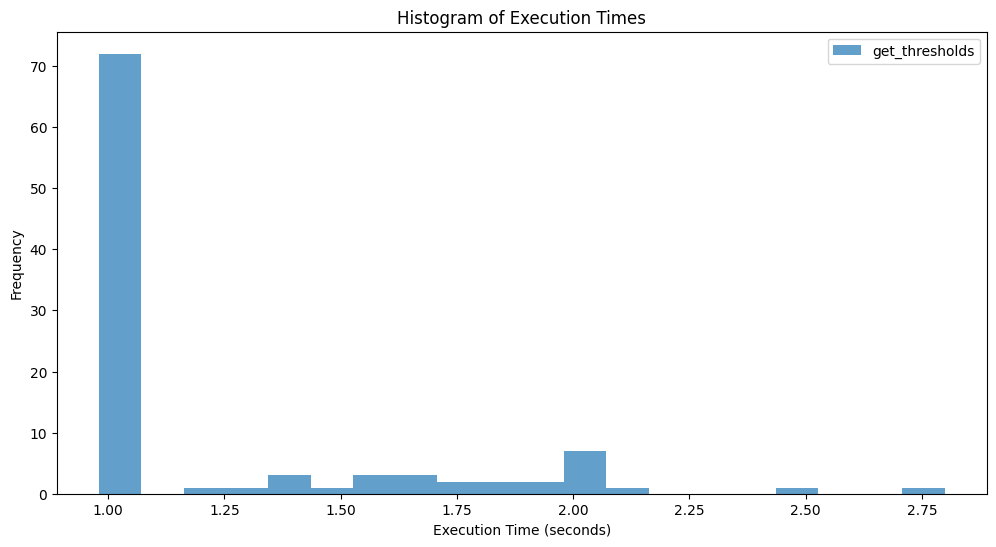

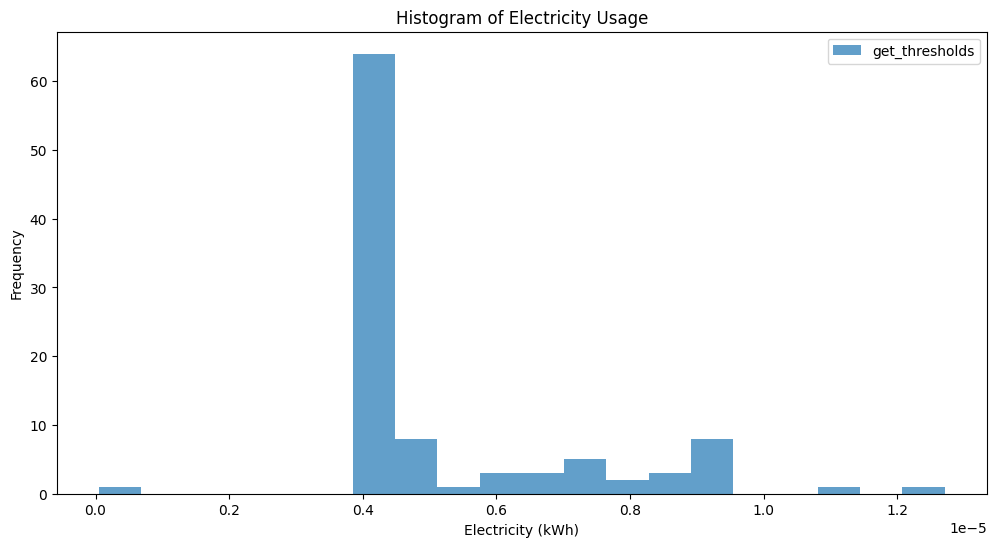

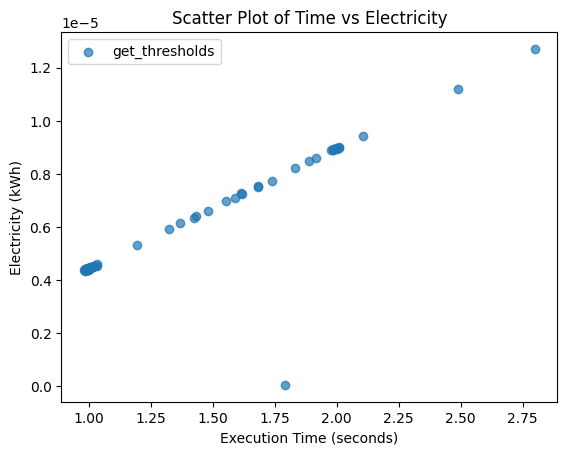

CPU times: user 2min 57s, sys: 1.41 s, total: 2min 58s
Wall time: 5min 16s


In [ ]:
%%time
run_simulations([get_thresholds], [key_scores, non_key_scores, K],100)

[codecarbon INFO @ 07:04:37] [setup] RAM Tracking...
[codecarbon INFO @ 07:04:37] [setup] GPU Tracking...
[codecarbon INFO @ 07:04:37] No GPU found.
[codecarbon INFO @ 07:04:37] [setup] CPU Tracking...
[codecarbon WARNING @ 07:04:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 07:04:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:39] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:39]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:39]   Python version: 3.10.12
[codecarbon INFO @ 07:04:39]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:39]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:39]   CPU count: 2
[codecarbon INFO @ 07:04:39]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:39]   GPU count: None
[cod

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:04:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:44] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:44]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:44]   Python version: 3.10.12
[codecarbon INFO @ 07:04:44]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:44]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:44]   CPU count: 2
[codecarbon INFO @ 07:04:44]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:44]   GPU count: None
[codecarbon INFO @ 07:04:44]   GPU model: None
[codecarbon INFO @ 07:04:46] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:46] Energy consumed for all CPUs : 0.000018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:46] 0.000020 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:04:46] Energy consumed for RAM : 0.004732 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:46] Energy consumed for all CPUs : 0.042317 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:46] 0.047049 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:04:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:47] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:47] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:47]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:47]   Python version: 3.10.12
[codecarbon INFO @ 07:04:47]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:47]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:47]   CPU count: 2
[codecarbon INFO @ 07:04:47]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:47]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:04:50] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:50] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:50] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:50]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:50]   Python version: 3.10.12
[codecarbon INFO @ 07:04:50]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:50]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:50]   CPU count: 2
[codecarbon INFO @ 07:04:50]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:50]   GPU count: None
[codecarbon INFO @ 07:04:50]   GPU model: None
[codecarbon INFO @ 07:04:51] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:51] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:51] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:04:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:52] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:52]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:52]   Python version: 3.10.12
[codecarbon INFO @ 07:04:52]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:52]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:52]   CPU count: 2
[codecarbon INFO @ 07:04:52]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:52]   GPU count: None
[codecarbon INFO @ 07:04:52]   GPU model: None
[codecarbon INFO @ 07:04:53] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:53] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:53] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:04:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:55] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:55]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:55]   Python version: 3.10.12
[codecarbon INFO @ 07:04:55]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:55]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:55]   CPU count: 2
[codecarbon INFO @ 07:04:55]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:55]   GPU count: None
[codecarbon INFO @ 07:04:55]   GPU model: None
[codecarbon INFO @ 07:04:56] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:56] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:56] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:04:56] Energy consumed for RAM : 0.004891 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:04:56] Energy consumed for all CPUs : 0.043734 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:04:56] 0.048624 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:04:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:04:58] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:58] >>> Tracker's metadata:
[codecarbon INFO @ 07:04:58]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:04:58]   Python version: 3.10.12
[codecarbon INFO @ 07:04:58]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:04:58]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:04:58]   CPU count: 2
[codecarbon INFO @ 07:04:58]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:04:58]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:01] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:01]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:01]   Python version: 3.10.12
[codecarbon INFO @ 07:05:01]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:01]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:01]   CPU count: 2
[codecarbon INFO @ 07:05:01]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:01]   GPU count: None
[codecarbon INFO @ 07:05:01]   GPU model: None
[codecarbon INFO @ 07:05:01] Energy consumed for RAM : 0.004752 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:02] Energy consumed for all CPUs : 0.042494 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:02] 0.047247 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:04] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:04]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:04]   Python version: 3.10.12
[codecarbon INFO @ 07:05:04]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:04]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:04]   CPU count: 2
[codecarbon INFO @ 07:05:04]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:04]   GPU count: None
[codecarbon INFO @ 07:05:04]   GPU model: None
[codecarbon INFO @ 07:05:05] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:05] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:05] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:06] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:06]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:06]   Python version: 3.10.12
[codecarbon INFO @ 07:05:06]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:06]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:06]   CPU count: 2
[codecarbon INFO @ 07:05:06]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:06]   GPU count: None
[codecarbon INFO @ 07:05:06]   GPU model: None
[codecarbon INFO @ 07:05:07] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:07] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:07] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:09] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:09] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:09]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:09]   Python version: 3.10.12
[codecarbon INFO @ 07:05:09]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:09]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:09]   CPU count: 2
[codecarbon INFO @ 07:05:09]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:09]   GPU count: None
[codecarbon INFO @ 07:05:09]   GPU model: None
[codecarbon INFO @ 07:05:10] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:10] Energy consumed for all CPUs : 0.000017 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:10] 0.000019 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:05:11] Energy consumed for RAM : 0.004911 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:11] Energy consumed for all CPUs : 0.043911 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:11] 0.048821 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:05:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:12] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:12]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:12]   Python version: 3.10.12
[codecarbon INFO @ 07:05:12]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:12]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:12]   CPU count: 2
[codecarbon INFO @ 07:05:12]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:12]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:15] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:15]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:15]   Python version: 3.10.12
[codecarbon INFO @ 07:05:15]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:15]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:15]   CPU count: 2
[codecarbon INFO @ 07:05:15]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:15]   GPU count: None
[codecarbon INFO @ 07:05:15]   GPU model: None
[codecarbon INFO @ 07:05:16] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:16] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:16] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:05:16] Energy consumed for RAM : 0.004772 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:16] Energy consumed for all CPUs : 0.042671 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:16] 0.047443 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:05:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:17] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:17]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:17]   Python version: 3.10.12
[codecarbon INFO @ 07:05:17]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:17]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:17]   CPU count: 2
[codecarbon INFO @ 07:05:17]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:17]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:20] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:20]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:20]   Python version: 3.10.12
[codecarbon INFO @ 07:05:20]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:20]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:20]   CPU count: 2
[codecarbon INFO @ 07:05:20]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:20]   GPU count: None
[codecarbon INFO @ 07:05:20]   GPU model: None
[codecarbon INFO @ 07:05:21] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:21] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:21] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:23] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:23]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:23]   Python version: 3.10.12
[codecarbon INFO @ 07:05:23]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:23]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:23]   CPU count: 2
[codecarbon INFO @ 07:05:23]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:23]   GPU count: None
[codecarbon INFO @ 07:05:23]   GPU model: None
[codecarbon INFO @ 07:05:25] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:25] Energy consumed for all CPUs : 0.000017 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:25] 0.000019 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:26] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:26]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:26]   Python version: 3.10.12
[codecarbon INFO @ 07:05:26]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:26]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:26]   CPU count: 2
[codecarbon INFO @ 07:05:26]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:26]   GPU count: None
[codecarbon INFO @ 07:05:26]   GPU model: None
[codecarbon INFO @ 07:05:26] Energy consumed for RAM : 0.004930 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:26] Energy consumed for all CPUs : 0.044088 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:26] 0.049018 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:29] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:29]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:29]   Python version: 3.10.12
[codecarbon INFO @ 07:05:29]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:29]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:29]   CPU count: 2
[codecarbon INFO @ 07:05:29]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:29]   GPU count: None
[codecarbon INFO @ 07:05:29]   GPU model: None
[codecarbon INFO @ 07:05:30] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:30] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:30] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:31] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:31]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:31]   Python version: 3.10.12
[codecarbon INFO @ 07:05:31]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:31]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:31]   CPU count: 2
[codecarbon INFO @ 07:05:31]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:31]   GPU count: None
[codecarbon INFO @ 07:05:31]   GPU model: None
[codecarbon INFO @ 07:05:31] Energy consumed for RAM : 0.004792 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:31] Energy consumed for all CPUs : 0.042848 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:31] 0.047640 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:34] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:34] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:34]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:34]   Python version: 3.10.12
[codecarbon INFO @ 07:05:34]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:34]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:34]   CPU count: 2
[codecarbon INFO @ 07:05:34]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:34]   GPU count: None
[codecarbon INFO @ 07:05:34]   GPU model: None
[codecarbon INFO @ 07:05:35] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:35] Energy consumed for all CPUs : 0.000014 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:35] 0.000016 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:37] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:37]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:37]   Python version: 3.10.12
[codecarbon INFO @ 07:05:37]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:37]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:37]   CPU count: 2
[codecarbon INFO @ 07:05:37]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:37]   GPU count: None
[codecarbon INFO @ 07:05:37]   GPU model: None
[codecarbon INFO @ 07:05:38] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:38] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:38] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:40] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:40] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:40]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:40]   Python version: 3.10.12
[codecarbon INFO @ 07:05:40]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:40]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:40]   CPU count: 2
[codecarbon INFO @ 07:05:40]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:40]   GPU count: None
[codecarbon INFO @ 07:05:40]   GPU model: None
[codecarbon INFO @ 07:05:41] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:41] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:41] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:05:41] Energy consumed for RAM : 0.004950 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:41] Energy consumed for all CPUs : 0.044265 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:41] 0.049215 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:05:42] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:42] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:42] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:42]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:43]   Python version: 3.10.12
[codecarbon INFO @ 07:05:43]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:43]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:43]   CPU count: 2
[codecarbon INFO @ 07:05:43]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:43]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:45] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:45] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:45] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:45]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:45]   Python version: 3.10.12
[codecarbon INFO @ 07:05:45]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:45]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:45]   CPU count: 2
[codecarbon INFO @ 07:05:45]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:45]   GPU count: None
[codecarbon INFO @ 07:05:45]   GPU model: None
[codecarbon INFO @ 07:05:46] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:46] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:46] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:05:46] Energy consumed for RAM : 0.004812 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:46] Energy consumed for all CPUs : 0.043025 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:46] 0.047837 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:05:48] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:48] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:48] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:48]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:48]   Python version: 3.10.12
[codecarbon INFO @ 07:05:48]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:48]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:48]   CPU count: 2
[codecarbon INFO @ 07:05:48]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:48]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:51] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:51] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:51]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:51]   Python version: 3.10.12
[codecarbon INFO @ 07:05:51]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:51]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:51]   CPU count: 2
[codecarbon INFO @ 07:05:51]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:51]   GPU count: None
[codecarbon INFO @ 07:05:51]   GPU model: None
[codecarbon INFO @ 07:05:52] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:52] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:52] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:54] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:54]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:54]   Python version: 3.10.12
[codecarbon INFO @ 07:05:54]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:54]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:54]   CPU count: 2
[codecarbon INFO @ 07:05:54]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:54]   GPU count: None
[codecarbon INFO @ 07:05:54]   GPU model: None
[codecarbon INFO @ 07:05:55] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:55] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:55] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:05:56] Energy consumed for RAM : 0.004970 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:05:56] Energy consumed for all CPUs : 0.044442 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:05:56] 0.049412 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:05:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:57] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:57]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:57]   Python version: 3.10.12
[codecarbon INFO @ 07:05:57]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:57]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:57]   CPU count: 2
[codecarbon INFO @ 07:05:57]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:57]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:05:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:05:59] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:59] >>> Tracker's metadata:
[codecarbon INFO @ 07:05:59]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:05:59]   Python version: 3.10.12
[codecarbon INFO @ 07:05:59]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:05:59]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:05:59]   CPU count: 2
[codecarbon INFO @ 07:05:59]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:05:59]   GPU count: None
[codecarbon INFO @ 07:05:59]   GPU model: None
[codecarbon INFO @ 07:06:00] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:00] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:00] 0.000012 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:06:01] Energy consumed for RAM : 0.004831 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:01] Energy consumed for all CPUs : 0.043202 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:01] 0.048034 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:06:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:02] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:02] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:02]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:02]   Python version: 3.10.12
[codecarbon INFO @ 07:06:02]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:02]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:02]   CPU count: 2
[codecarbon INFO @ 07:06:02]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:02]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:05] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:05] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:05]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:05]   Python version: 3.10.12
[codecarbon INFO @ 07:06:05]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:05]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:05]   CPU count: 2
[codecarbon INFO @ 07:06:05]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:05]   GPU count: None
[codecarbon INFO @ 07:06:05]   GPU model: None
[codecarbon INFO @ 07:06:06] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:06] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:06] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:08] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:08]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:08]   Python version: 3.10.12
[codecarbon INFO @ 07:06:08]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:08]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:08]   CPU count: 2
[codecarbon INFO @ 07:06:08]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:08]   GPU count: None
[codecarbon INFO @ 07:06:08]   GPU model: None
[codecarbon INFO @ 07:06:09] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:09] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:09] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:10] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:10] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:10] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:10]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:10]   Python version: 3.10.12
[codecarbon INFO @ 07:06:10]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:10]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:10]   CPU count: 2
[codecarbon INFO @ 07:06:10]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:10]   GPU count: None
[codecarbon INFO @ 07:06:10]   GPU model: None
[codecarbon INFO @ 07:06:11] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:11] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:11] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:13] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:13]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:13]   Python version: 3.10.12
[codecarbon INFO @ 07:06:13]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:13]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:13]   CPU count: 2
[codecarbon INFO @ 07:06:13]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:13]   GPU count: None
[codecarbon INFO @ 07:06:13]   GPU model: None
[codecarbon INFO @ 07:06:15] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:15] Energy consumed for all CPUs : 0.000018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:15] 0.000020 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:16] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:16]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:16]   Python version: 3.10.12
[codecarbon INFO @ 07:06:16]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:16]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:16]   CPU count: 2
[codecarbon INFO @ 07:06:16]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:16]   GPU count: None
[codecarbon INFO @ 07:06:16]   GPU model: None
[codecarbon INFO @ 07:06:16] Energy consumed for RAM : 0.004851 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:16] Energy consumed for all CPUs : 0.043379 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:16] 0.048230 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:19] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:19] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:19]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:19]   Python version: 3.10.12
[codecarbon INFO @ 07:06:19]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:19]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:19]   CPU count: 2
[codecarbon INFO @ 07:06:19]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:19]   GPU count: None
[codecarbon INFO @ 07:06:19]   GPU model: None
[codecarbon INFO @ 07:06:20] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:20] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:20] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:22] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:22]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:22]   Python version: 3.10.12
[codecarbon INFO @ 07:06:22]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:22]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:22]   CPU count: 2
[codecarbon INFO @ 07:06:22]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:22]   GPU count: None
[codecarbon INFO @ 07:06:22]   GPU model: None
[codecarbon INFO @ 07:06:23] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:23] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:23] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:24] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:24]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:24]   Python version: 3.10.12
[codecarbon INFO @ 07:06:24]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:24]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:24]   CPU count: 2
[codecarbon INFO @ 07:06:24]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:24]   GPU count: None
[codecarbon INFO @ 07:06:24]   GPU model: None
[codecarbon INFO @ 07:06:25] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:25] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:25] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:06:26] Energy consumed for RAM : 0.005010 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:26] Energy consumed for all CPUs : 0.044796 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:26] 0.049806 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:06:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:27] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:27]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:27]   Python version: 3.10.12
[codecarbon INFO @ 07:06:27]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:27]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:27]   CPU count: 2
[codecarbon INFO @ 07:06:27]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:27]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:30] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:30]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:30]   Python version: 3.10.12
[codecarbon INFO @ 07:06:30]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:30]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:30]   CPU count: 2
[codecarbon INFO @ 07:06:30]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:30]   GPU count: None
[codecarbon INFO @ 07:06:30]   GPU model: None
[codecarbon INFO @ 07:06:31] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:31] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:31] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:06:31] Energy consumed for RAM : 0.004871 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:31] Energy consumed for all CPUs : 0.043556 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:31] 0.048427 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:06:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:33] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:33]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:33]   Python version: 3.10.12
[codecarbon INFO @ 07:06:33]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:33]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:33]   CPU count: 2
[codecarbon INFO @ 07:06:33]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:33]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:35] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:35]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:35]   Python version: 3.10.12
[codecarbon INFO @ 07:06:35]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:35]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:35]   CPU count: 2
[codecarbon INFO @ 07:06:35]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:35]   GPU count: None
[codecarbon INFO @ 07:06:35]   GPU model: None
[codecarbon INFO @ 07:06:36] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:36] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:36] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:38] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:38] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:38]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:38]   Python version: 3.10.12
[codecarbon INFO @ 07:06:38]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:38]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:38]   CPU count: 2
[codecarbon INFO @ 07:06:38]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:38]   GPU count: None
[codecarbon INFO @ 07:06:38]   GPU model: None
[codecarbon INFO @ 07:06:39] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:39] Energy consumed for all CPUs : 0.000017 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:39] 0.000018 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:41] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:41] Energy consumed for RAM : 0.005029 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:41] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:41]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:41]   Python version: 3.10.12
[codecarbon INFO @ 07:06:41] Energy consumed for all CPUs : 0.044974 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:41] 0.050003 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:06:41]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:41]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:41]   CPU count: 2
[codecarbon INFO @ 07:06:41]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:41]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:44] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:44]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:44]   Python version: 3.10.12
[codecarbon INFO @ 07:06:44]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:44]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:44]   CPU count: 2
[codecarbon INFO @ 07:06:44]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:44]   GPU count: None
[codecarbon INFO @ 07:06:44]   GPU model: None
[codecarbon INFO @ 07:06:45] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:45] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:45] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:46] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:46]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:46]   Python version: 3.10.12
[codecarbon INFO @ 07:06:46]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:46]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:46]   CPU count: 2
[codecarbon INFO @ 07:06:46]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:46]   GPU count: None
[codecarbon INFO @ 07:06:46]   GPU model: None
[codecarbon INFO @ 07:06:46] Energy consumed for RAM : 0.004891 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:47] Energy consumed for all CPUs : 0.043733 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:47] 0.048624 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:49] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:49]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:49]   Python version: 3.10.12
[codecarbon INFO @ 07:06:49]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:49]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:49]   CPU count: 2
[codecarbon INFO @ 07:06:49]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:49]   GPU count: None
[codecarbon INFO @ 07:06:49]   GPU model: None
[codecarbon INFO @ 07:06:50] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:50] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:50] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:52] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:52]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:52]   Python version: 3.10.12
[codecarbon INFO @ 07:06:52]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:52]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:52]   CPU count: 2
[codecarbon INFO @ 07:06:52]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:52]   GPU count: None
[codecarbon INFO @ 07:06:52]   GPU model: None
[codecarbon INFO @ 07:06:54] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:54] Energy consumed for all CPUs : 0.000018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:54] 0.000020 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:55] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:55]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:55]   Python version: 3.10.12
[codecarbon INFO @ 07:06:55]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:55]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:55]   CPU count: 2
[codecarbon INFO @ 07:06:55]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:55]   GPU count: None
[codecarbon INFO @ 07:06:55]   GPU model: None
[codecarbon INFO @ 07:06:56] Energy consumed for RAM : 0.005049 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:56] Energy consumed for all CPUs : 0.045151 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:56] 0.050200 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:06:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:06:58] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:58] >>> Tracker's metadata:
[codecarbon INFO @ 07:06:58]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:06:58]   Python version: 3.10.12
[codecarbon INFO @ 07:06:58]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:06:58]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:06:58]   CPU count: 2
[codecarbon INFO @ 07:06:58]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:06:58]   GPU count: None
[codecarbon INFO @ 07:06:58]   GPU model: None
[codecarbon INFO @ 07:06:59] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:06:59] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:06:59] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:01] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:01]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:01]   Python version: 3.10.12
[codecarbon INFO @ 07:07:01]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:01]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:01]   CPU count: 2
[codecarbon INFO @ 07:07:01]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:01]   GPU count: None
[codecarbon INFO @ 07:07:01]   GPU model: None
[codecarbon INFO @ 07:07:02] Energy consumed for RAM : 0.004911 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:02] Energy consumed for all CPUs : 0.043911 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:02] 0.048821 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:03] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:03]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:03]   Python version: 3.10.12
[codecarbon INFO @ 07:07:03]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:03]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:03]   CPU count: 2
[codecarbon INFO @ 07:07:03]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:03]   GPU count: None
[codecarbon INFO @ 07:07:03]   GPU model: None
[codecarbon INFO @ 07:07:05] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:05] Energy consumed for all CPUs : 0.000014 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:05] 0.000016 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:07] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:07] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:07] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:07]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:07]   Python version: 3.10.12
[codecarbon INFO @ 07:07:07]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:07]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:07]   CPU count: 2
[codecarbon INFO @ 07:07:07]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:07]   GPU count: None
[codecarbon INFO @ 07:07:07]   GPU model: None
[codecarbon INFO @ 07:07:08] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:08] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:08] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:09] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:09] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:09]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:09]   Python version: 3.10.12
[codecarbon INFO @ 07:07:09]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:09]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:09]   CPU count: 2
[codecarbon INFO @ 07:07:09]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:09]   GPU count: None
[codecarbon INFO @ 07:07:09]   GPU model: None
[codecarbon INFO @ 07:07:10] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:10] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:10] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:07:11] Energy consumed for RAM : 0.005069 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:11] Energy consumed for all CPUs : 0.045327 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:11] 0.050396 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:07:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:12] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:12]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:12]   Python version: 3.10.12
[codecarbon INFO @ 07:07:12]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:12]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:12]   CPU count: 2
[codecarbon INFO @ 07:07:12]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:12]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:15] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:15]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:15]   Python version: 3.10.12
[codecarbon INFO @ 07:07:15]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:15]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:15]   CPU count: 2
[codecarbon INFO @ 07:07:15]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:15]   GPU count: None
[codecarbon INFO @ 07:07:15]   GPU model: None
[codecarbon INFO @ 07:07:16] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:16] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:16] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:07:17] Energy consumed for RAM : 0.004930 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:17] Energy consumed for all CPUs : 0.044087 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:17] 0.049018 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:07:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:18] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:18]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:18]   Python version: 3.10.12
[codecarbon INFO @ 07:07:18]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:18]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:18]   CPU count: 2
[codecarbon INFO @ 07:07:18]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:18]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:21] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:21] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:21]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:21]   Python version: 3.10.12
[codecarbon INFO @ 07:07:21]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:21]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:21]   CPU count: 2
[codecarbon INFO @ 07:07:21]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:21]   GPU count: None
[codecarbon INFO @ 07:07:21]   GPU model: None
[codecarbon INFO @ 07:07:22] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:22] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:22] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:23] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:23]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:24]   Python version: 3.10.12
[codecarbon INFO @ 07:07:24]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:24]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:24]   CPU count: 2
[codecarbon INFO @ 07:07:24]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:24]   GPU count: None
[codecarbon INFO @ 07:07:24]   GPU model: None
[codecarbon INFO @ 07:07:25] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:25] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:25] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:26] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:26]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:26]   Python version: 3.10.12
[codecarbon INFO @ 07:07:26]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:26]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:26]   CPU count: 2
[codecarbon INFO @ 07:07:26] Energy consumed for RAM : 0.005089 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:26] Energy consumed for all CPUs : 0.045505 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:26] 0.050593 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:07:26]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:26]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:29] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:29]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:29]   Python version: 3.10.12
[codecarbon INFO @ 07:07:29]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:29]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:29]   CPU count: 2
[codecarbon INFO @ 07:07:29]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:29]   GPU count: None
[codecarbon INFO @ 07:07:29]   GPU model: None
[codecarbon INFO @ 07:07:31] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:31] Energy consumed for all CPUs : 0.000017 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:31] 0.000019 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:07:32] Energy consumed for RAM : 0.004950 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:32] Energy consumed for all CPUs : 0.044265 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:32] 0.049215 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:07:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:32] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:32]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:32]   Python version: 3.10.12
[codecarbon INFO @ 07:07:32]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:32]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:32]   CPU count: 2
[codecarbon INFO @ 07:07:32]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:32]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:35] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:35]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:35]   Python version: 3.10.12
[codecarbon INFO @ 07:07:35]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:35]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:35]   CPU count: 2
[codecarbon INFO @ 07:07:35]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:35]   GPU count: None
[codecarbon INFO @ 07:07:35]   GPU model: None
[codecarbon INFO @ 07:07:36] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:36] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:36] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:38] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:38] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:38]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:38]   Python version: 3.10.12
[codecarbon INFO @ 07:07:38]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:38]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:38]   CPU count: 2
[codecarbon INFO @ 07:07:38]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:38]   GPU count: None
[codecarbon INFO @ 07:07:38]   GPU model: None
[codecarbon INFO @ 07:07:39] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:39] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:39] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:40] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:40] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:40]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:40]   Python version: 3.10.12
[codecarbon INFO @ 07:07:40]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:40]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:40]   CPU count: 2
[codecarbon INFO @ 07:07:40]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:40]   GPU count: None
[codecarbon INFO @ 07:07:40]   GPU model: None
[codecarbon INFO @ 07:07:41] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:41] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:41] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:43] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:43]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:43]   Python version: 3.10.12
[codecarbon INFO @ 07:07:43]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:43]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:43]   CPU count: 2
[codecarbon INFO @ 07:07:43]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:43]   GPU count: None
[codecarbon INFO @ 07:07:43]   GPU model: None
[codecarbon INFO @ 07:07:45] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:45] Energy consumed for all CPUs : 0.000018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:45] 0.000020 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:46] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:46]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:46]   Python version: 3.10.12
[codecarbon INFO @ 07:07:46]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:46]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:46]   CPU count: 2
[codecarbon INFO @ 07:07:46]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:46]   GPU count: None
[codecarbon INFO @ 07:07:46]   GPU model: None
[codecarbon INFO @ 07:07:47] Energy consumed for RAM : 0.004970 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:47] Energy consumed for all CPUs : 0.044442 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:47] 0.049412 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:49] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:49]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:49]   Python version: 3.10.12
[codecarbon INFO @ 07:07:49]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:49]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:49]   CPU count: 2
[codecarbon INFO @ 07:07:49]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:49]   GPU count: None
[codecarbon INFO @ 07:07:49]   GPU model: None
[codecarbon INFO @ 07:07:50] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:50] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:50] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:52] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:52]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:52]   Python version: 3.10.12
[codecarbon INFO @ 07:07:52]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:52]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:52]   CPU count: 2
[codecarbon INFO @ 07:07:52]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:52]   GPU count: None
[codecarbon INFO @ 07:07:52]   GPU model: None
[codecarbon INFO @ 07:07:53] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:53] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:53] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:07:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:54] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:54]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:54]   Python version: 3.10.12
[codecarbon INFO @ 07:07:54]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:54]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:54]   CPU count: 2
[codecarbon INFO @ 07:07:54]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:54]   GPU count: None
[codecarbon INFO @ 07:07:54]   GPU model: None
[codecarbon INFO @ 07:07:56] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:56] Energy consumed for all CPUs : 0.000014 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:56] 0.000015 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:07:56] Energy consumed for RAM : 0.005128 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:07:56] Energy consumed for all CPUs : 0.045859 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:07:56] 0.050987 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:07:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:07:58] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:58] >>> Tracker's metadata:
[codecarbon INFO @ 07:07:58]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:07:58]   Python version: 3.10.12
[codecarbon INFO @ 07:07:58]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:07:58]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:07:58]   CPU count: 2
[codecarbon INFO @ 07:07:58]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:07:58]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:01] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:01]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:01]   Python version: 3.10.12
[codecarbon INFO @ 07:08:01]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:01]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:01]   CPU count: 2
[codecarbon INFO @ 07:08:01]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:01]   GPU count: None
[codecarbon INFO @ 07:08:01]   GPU model: None
[codecarbon INFO @ 07:08:02] Energy consumed for RAM : 0.004990 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:02] Energy consumed for all CPUs : 0.044619 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:02] 0.049609 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:04] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:04]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:04]   Python version: 3.10.12
[codecarbon INFO @ 07:08:04]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:04]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:04]   CPU count: 2
[codecarbon INFO @ 07:08:04]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:04]   GPU count: None
[codecarbon INFO @ 07:08:04]   GPU model: None
[codecarbon INFO @ 07:08:05] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:05] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:05] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:07] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:07] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:07] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:07]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:07]   Python version: 3.10.12
[codecarbon INFO @ 07:08:07]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:07]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:07]   CPU count: 2
[codecarbon INFO @ 07:08:07]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:07]   GPU count: None
[codecarbon INFO @ 07:08:07]   GPU model: None
[codecarbon INFO @ 07:08:08] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:08] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:08] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:10] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:10] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:10] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:10]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:10]   Python version: 3.10.12
[codecarbon INFO @ 07:08:10]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:10]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:10]   CPU count: 2
[codecarbon INFO @ 07:08:10]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:10]   GPU count: None
[codecarbon INFO @ 07:08:10]   GPU model: None
[codecarbon INFO @ 07:08:11] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:11] Energy consumed for all CPUs : 0.000011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:11] 0.000012 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:08:11] Energy consumed for RAM : 0.005148 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:11] Energy consumed for all CPUs : 0.046036 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:11] 0.051184 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:08:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:13] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:13]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:13]   Python version: 3.10.12
[codecarbon INFO @ 07:08:13]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:13]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:13]   CPU count: 2
[codecarbon INFO @ 07:08:13]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:13]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:15] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:15]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:15]   Python version: 3.10.12
[codecarbon INFO @ 07:08:15]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:15]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:15]   CPU count: 2
[codecarbon INFO @ 07:08:15]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:15]   GPU count: None
[codecarbon INFO @ 07:08:15]   GPU model: None
[codecarbon INFO @ 07:08:16] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:16] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:16] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:08:17] Energy consumed for RAM : 0.005010 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:17] Energy consumed for all CPUs : 0.044796 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:17] 0.049806 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:08:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:18] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:18]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:18]   Python version: 3.10.12
[codecarbon INFO @ 07:08:18]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:18]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:18]   CPU count: 2
[codecarbon INFO @ 07:08:18]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:18]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:20] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:20]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:20]   Python version: 3.10.12
[codecarbon INFO @ 07:08:20]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:20]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:20]   CPU count: 2
[codecarbon INFO @ 07:08:20]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:20]   GPU count: None
[codecarbon INFO @ 07:08:20]   GPU model: None
[codecarbon INFO @ 07:08:22] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:22] Energy consumed for all CPUs : 0.000018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:22] 0.000020 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:24] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:24]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:24]   Python version: 3.10.12
[codecarbon INFO @ 07:08:24]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:24]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:24]   CPU count: 2
[codecarbon INFO @ 07:08:24]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:24]   GPU count: None
[codecarbon INFO @ 07:08:24]   GPU model: None
[codecarbon INFO @ 07:08:25] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:25] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:25] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:08:26] Energy consumed for RAM : 0.005168 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:26] Energy consumed for all CPUs : 0.046213 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:26] 0.051381 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:08:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:26] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:26]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:26]   Python version: 3.10.12
[codecarbon INFO @ 07:08:26]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:26]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:26]   CPU count: 2
[codecarbon INFO @ 07:08:26]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:26]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:29] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:29]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:29]   Python version: 3.10.12
[codecarbon INFO @ 07:08:29]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:29]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:29]   CPU count: 2
[codecarbon INFO @ 07:08:29]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:29]   GPU count: None
[codecarbon INFO @ 07:08:29]   GPU model: None
[codecarbon INFO @ 07:08:30] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:30] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:30] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:08:32] Energy consumed for RAM : 0.005029 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:32] Energy consumed for all CPUs : 0.044974 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:32] 0.050003 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:08:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:32] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:32]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:32]   Python version: 3.10.12
[codecarbon INFO @ 07:08:32]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:32]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:32]   CPU count: 2
[codecarbon INFO @ 07:08:32]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:32]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:35] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:35]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:35]   Python version: 3.10.12
[codecarbon INFO @ 07:08:35]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:35]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:35]   CPU count: 2
[codecarbon INFO @ 07:08:35]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:35]   GPU count: None
[codecarbon INFO @ 07:08:35]   GPU model: None
[codecarbon INFO @ 07:08:36] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:36] Energy consumed for all CPUs : 0.000014 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:36] 0.000016 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:38] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:38] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:38]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:38]   Python version: 3.10.12
[codecarbon INFO @ 07:08:38]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:38]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:38]   CPU count: 2
[codecarbon INFO @ 07:08:38]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:38]   GPU count: None
[codecarbon INFO @ 07:08:38]   GPU model: None
[codecarbon INFO @ 07:08:39] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:39] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:39] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:40] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:40] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:40]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:40]   Python version: 3.10.12
[codecarbon INFO @ 07:08:40]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:40]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:40]   CPU count: 2
[codecarbon INFO @ 07:08:40]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:40]   GPU count: None
[codecarbon INFO @ 07:08:40]   GPU model: None
[codecarbon INFO @ 07:08:41] Energy consumed for RAM : 0.005188 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:41] Energy consumed for all CPUs : 0.046390 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:41] 0.051578 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:43] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:43]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:43]   Python version: 3.10.12
[codecarbon INFO @ 07:08:43]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:43]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:43]   CPU count: 2
[codecarbon INFO @ 07:08:43]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:43]   GPU count: None
[codecarbon INFO @ 07:08:43]   GPU model: None
[codecarbon INFO @ 07:08:44] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:44] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:44] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:46] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:46]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:46]   Python version: 3.10.12
[codecarbon INFO @ 07:08:46]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:46]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:46]   CPU count: 2
[codecarbon INFO @ 07:08:46]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:46]   GPU count: None
[codecarbon INFO @ 07:08:46]   GPU model: None
[codecarbon INFO @ 07:08:47] Energy consumed for RAM : 0.005049 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:47] Energy consumed for all CPUs : 0.045150 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:47] 0.050199 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:49] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:49]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:49]   Python version: 3.10.12
[codecarbon INFO @ 07:08:49]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:49]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:49]   CPU count: 2
[codecarbon INFO @ 07:08:49]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:49]   GPU count: None
[codecarbon INFO @ 07:08:49]   GPU model: None
[codecarbon INFO @ 07:08:50] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:50] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:50] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:52] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:52]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:52]   Python version: 3.10.12
[codecarbon INFO @ 07:08:52]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:52]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:52]   CPU count: 2
[codecarbon INFO @ 07:08:52]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:52]   GPU count: None
[codecarbon INFO @ 07:08:52]   GPU model: None
[codecarbon INFO @ 07:08:53] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:53] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:53] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:08:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:54] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:54]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:54]   Python version: 3.10.12
[codecarbon INFO @ 07:08:54]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:54]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:54]   CPU count: 2
[codecarbon INFO @ 07:08:54]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:54]   GPU count: None
[codecarbon INFO @ 07:08:54]   GPU model: None
[codecarbon INFO @ 07:08:55] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:55] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:55] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:08:56] Energy consumed for RAM : 0.005208 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:08:56] Energy consumed for all CPUs : 0.046567 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:08:56] 0.051774 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:08:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:08:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:57] >>> Tracker's metadata:
[codecarbon INFO @ 07:08:57]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:08:57]   Python version: 3.10.12
[codecarbon INFO @ 07:08:57]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:08:57]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:08:57]   CPU count: 2
[codecarbon INFO @ 07:08:57]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:08:57]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:09:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:00] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:00] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:00]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:00]   Python version: 3.10.12
[codecarbon INFO @ 07:09:00]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:00]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:00]   CPU count: 2
[codecarbon INFO @ 07:09:00]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:00]   GPU count: None
[codecarbon INFO @ 07:09:00]   GPU model: None
[codecarbon INFO @ 07:09:02] Energy consumed for RAM : 0.000002 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:02] Energy consumed for all CPUs : 0.000017 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:02] 0.000019 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:09:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:03] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:03]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:03]   Python version: 3.10.12
[codecarbon INFO @ 07:09:03]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:03]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:03]   CPU count: 2
[codecarbon INFO @ 07:09:03]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:03]   GPU count: None
[codecarbon INFO @ 07:09:03]   GPU model: None
[codecarbon INFO @ 07:09:04] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:04] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:04] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:09:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:06] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:06]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:06]   Python version: 3.10.12
[codecarbon INFO @ 07:09:06]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:06]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:06]   CPU count: 2
[codecarbon INFO @ 07:09:06]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:06]   GPU count: None
[codecarbon INFO @ 07:09:06]   GPU model: None
[codecarbon INFO @ 07:09:07] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:07] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:07] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:09:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:08] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:08]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:08]   Python version: 3.10.12
[codecarbon INFO @ 07:09:08]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:08]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:08]   CPU count: 2
[codecarbon INFO @ 07:09:08]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:08]   GPU count: None
[codecarbon INFO @ 07:09:08]   GPU model: None
[codecarbon INFO @ 07:09:09] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:09] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:09] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:09:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:11] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:11]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:11]   Python version: 3.10.12
[codecarbon INFO @ 07:09:11]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:11]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:11]   CPU count: 2
[codecarbon INFO @ 07:09:11]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:11]   GPU count: None
[codecarbon INFO @ 07:09:11]   GPU model: None
[codecarbon INFO @ 07:09:11] Energy consumed for RAM : 0.005227 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:11] Energy consumed for all CPUs : 0.046744 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:11] 0.051972 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:09:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:14] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:14]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:14]   Python version: 3.10.12
[codecarbon INFO @ 07:09:14]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:14]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:14]   CPU count: 2
[codecarbon INFO @ 07:09:14]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:14]   GPU count: None
[codecarbon INFO @ 07:09:14]   GPU model: None
[codecarbon INFO @ 07:09:15] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:15] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:15] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon INFO @ 07:09:17] Energy consumed for RAM : 0.005089 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:17] Energy consumed for all CPUs : 0.045504 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:17] 0.050593 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:09:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:17] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:17]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:17]   Python version: 3.10.12
[codecarbon INFO @ 07:09:17]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:17]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:17]   CPU count: 2
[codecarbon INFO @ 07:09:17]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:17]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


[codecarbon WARNING @ 07:09:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:20] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:20]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:20]   Python version: 3.10.12
[codecarbon INFO @ 07:09:20]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:20]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:20]   CPU count: 2
[codecarbon INFO @ 07:09:20]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:20]   GPU count: None
[codecarbon INFO @ 07:09:20]   GPU model: None
[codecarbon INFO @ 07:09:21] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:21] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:21] 0.000010 kWh of electrici

Max KL Divergence is:  1.6325137338232074
Threshold params: [0.37520446642031924, 0.5372943682579643, 0.6702064532510279, 0.8466928483722368, 0.999974756889868]


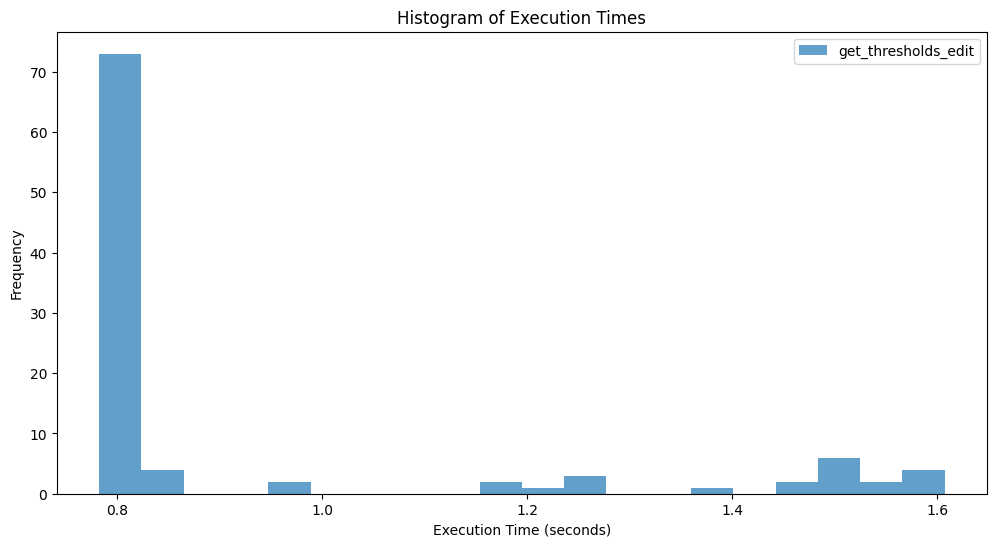

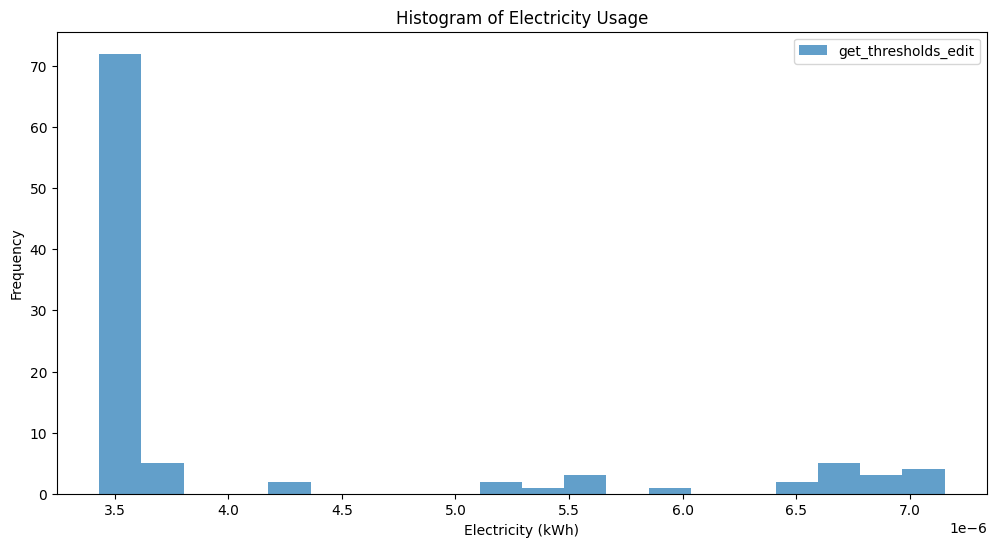

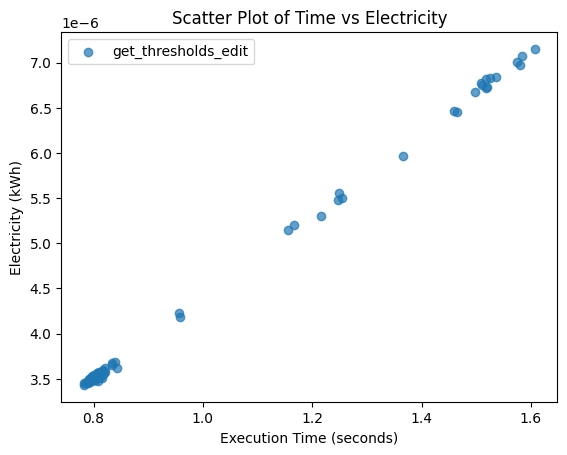

CPU times: user 2min 31s, sys: 1.61 s, total: 2min 32s
Wall time: 4min 44s


In [ ]:
%%time
run_simulations([get_thresholds_edit], [key_scores, non_key_scores, K],100)

[codecarbon INFO @ 07:09:22] [setup] RAM Tracking...
[codecarbon INFO @ 07:09:22] [setup] GPU Tracking...
[codecarbon INFO @ 07:09:22] No GPU found.
[codecarbon INFO @ 07:09:22] [setup] CPU Tracking...
[codecarbon WARNING @ 07:09:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 07:09:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:23] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:23]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:23]   Python version: 3.10.12
[codecarbon INFO @ 07:09:23]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:23]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:23]   CPU count: 2
[codecarbon INFO @ 07:09:23]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:23]   GPU count: None
[cod

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:09:26] Energy consumed for RAM : 0.005247 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:26] Energy consumed for all CPUs : 0.046921 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:26] 0.052168 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:09:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:27] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:27]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:27]   Python version: 3.10.12
[codecarbon INFO @ 07:09:27]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:27]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:27]   CPU count: 2
[codecarbon INFO @ 07:09:27]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:27]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:09:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:29] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:29]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:29]   Python version: 3.10.12
[codecarbon INFO @ 07:09:29]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:29]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:29]   CPU count: 2
[codecarbon INFO @ 07:09:29]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:29]   GPU count: None
[codecarbon INFO @ 07:09:29]   GPU model: None
[codecarbon INFO @ 07:09:30] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:30] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:30] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:09:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:31] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:31]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:31]   Python version: 3.10.12
[codecarbon INFO @ 07:09:31]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:31]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:31]   CPU count: 2
[codecarbon INFO @ 07:09:31]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:31]   GPU count: None
[codecarbon INFO @ 07:09:31]   GPU model: None
[codecarbon INFO @ 07:09:32] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:32] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:32] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:09:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:33] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:33]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:33]   Python version: 3.10.12
[codecarbon INFO @ 07:09:33]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:33]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:33]   CPU count: 2
[codecarbon INFO @ 07:09:33]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:33]   GPU count: None
[codecarbon INFO @ 07:09:33]   GPU model: None
[codecarbon INFO @ 07:09:33] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:33] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:33] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:09:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:35] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:35]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:35]   Python version: 3.10.12
[codecarbon INFO @ 07:09:35]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:35]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:35]   CPU count: 2
[codecarbon INFO @ 07:09:35]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:35]   GPU count: None
[codecarbon INFO @ 07:09:35]   GPU model: None
[codecarbon INFO @ 07:09:35] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:35] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:35] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:09:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:37] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:37]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:37]   Python version: 3.10.12
[codecarbon INFO @ 07:09:37]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:37]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:37]   CPU count: 2
[codecarbon INFO @ 07:09:37]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:37]   GPU count: None
[codecarbon INFO @ 07:09:37]   GPU model: None
[codecarbon INFO @ 07:09:37] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:37] Energy consumed for all CPUs : 0.000002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:37] 0.000002 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:09:37] [setup] RAM Tracking...
[codecarbon INFO @ 07:09:37] [setup] GPU Tracking...
[codecarbon INFO @ 07:09:37] No GPU found.
[codecarbon INFO @ 07:09:37] [setup] CPU Tracking...
[codecarbon WARNING @ 07:09:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 07:09:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:39] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:39]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:39]   Python version: 3.10.12
[codecarbon INFO @ 07:09:39]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:39]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:39]   CPU count: 2
[codecarbon INFO @ 07:09:39]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:39]   GPU count: None
[cod

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:09:41] Energy consumed for RAM : 0.005267 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:41] Energy consumed for all CPUs : 0.047099 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:41] 0.052366 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:09:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:41] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:41] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:41]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:41]   Python version: 3.10.12
[codecarbon INFO @ 07:09:41]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:41]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:41]   CPU count: 2
[codecarbon INFO @ 07:09:41]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:41]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:09:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:43] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:43]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:43]   Python version: 3.10.12
[codecarbon INFO @ 07:09:43]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:43]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:43]   CPU count: 2
[codecarbon INFO @ 07:09:43]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:43]   GPU count: None
[codecarbon INFO @ 07:09:43]   GPU model: None
[codecarbon INFO @ 07:09:44] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:44] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:44] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:09:45] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:45] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:45] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:45]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:45]   Python version: 3.10.12
[codecarbon INFO @ 07:09:45]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:45]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:45]   CPU count: 2
[codecarbon INFO @ 07:09:45]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:45]   GPU count: None
[codecarbon INFO @ 07:09:45]   GPU model: None
[codecarbon INFO @ 07:09:46] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:46] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:46] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:09:47] Energy consumed for RAM : 0.005128 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:47] Energy consumed for all CPUs : 0.045858 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:47] 0.050986 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:09:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:47] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:47] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:47]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:47]   Python version: 3.10.12
[codecarbon INFO @ 07:09:47]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:47]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:47]   CPU count: 2
[codecarbon INFO @ 07:09:47]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:47]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:09:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:49] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:49]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:49]   Python version: 3.10.12
[codecarbon INFO @ 07:09:49]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:49]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:49]   CPU count: 2
[codecarbon INFO @ 07:09:49]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:49]   GPU count: None
[codecarbon INFO @ 07:09:49]   GPU model: None
[codecarbon INFO @ 07:09:50] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:50] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:50] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:09:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:51] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:52] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:52]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:52]   Python version: 3.10.12
[codecarbon INFO @ 07:09:52]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:52]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:52]   CPU count: 2
[codecarbon INFO @ 07:09:52]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:52]   GPU count: None
[codecarbon INFO @ 07:09:52]   GPU model: None
[codecarbon INFO @ 07:09:52] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:52] Energy consumed for all CPUs : 0.000002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:52] 0.000002 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:09:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:54] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:54]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:54]   Python version: 3.10.12
[codecarbon INFO @ 07:09:54]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:54]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:54]   CPU count: 2
[codecarbon INFO @ 07:09:54]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:54]   GPU count: None
[codecarbon INFO @ 07:09:54]   GPU model: None
[codecarbon INFO @ 07:09:54] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:54] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:54] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:09:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:56] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:56] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:56]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:56]   Python version: 3.10.12
[codecarbon INFO @ 07:09:56]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:56]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:56]   CPU count: 2
[codecarbon INFO @ 07:09:56]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:56]   GPU count: None
[codecarbon INFO @ 07:09:56]   GPU model: None
[codecarbon INFO @ 07:09:56] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:56] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:56] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:09:56] Energy consumed for RAM : 0.005287 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:09:56] Energy consumed for all CPUs : 0.047275 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:09:56] 0.052562 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:09:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:57] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:57]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:57]   Python version: 3.10.12
[codecarbon INFO @ 07:09:57]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:57]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:57]   CPU count: 2
[codecarbon INFO @ 07:09:57]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:57]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:09:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:09:59] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:59] >>> Tracker's metadata:
[codecarbon INFO @ 07:09:59]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:09:59]   Python version: 3.10.12
[codecarbon INFO @ 07:09:59]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:09:59]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:09:59]   CPU count: 2
[codecarbon INFO @ 07:09:59]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:09:59]   GPU count: None
[codecarbon INFO @ 07:09:59]   GPU model: None
[codecarbon INFO @ 07:10:00] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:00] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:00] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:01] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:01]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:01]   Python version: 3.10.12
[codecarbon INFO @ 07:10:01]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:01]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:01]   CPU count: 2
[codecarbon INFO @ 07:10:01]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:01]   GPU count: None
[codecarbon INFO @ 07:10:01]   GPU model: None
[codecarbon INFO @ 07:10:02] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:02] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:02] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:04] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:04]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:04]   Python version: 3.10.12
[codecarbon INFO @ 07:10:04]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:04]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:04]   CPU count: 2
[codecarbon INFO @ 07:10:04]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:04]   GPU count: None
[codecarbon INFO @ 07:10:04]   GPU model: None
[codecarbon INFO @ 07:10:04] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:04] Energy consumed for all CPUs : 0.000002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:04] 0.000002 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:06] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:06]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:06]   Python version: 3.10.12
[codecarbon INFO @ 07:10:06]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:06]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:06]   CPU count: 2
[codecarbon INFO @ 07:10:06]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:06]   GPU count: None
[codecarbon INFO @ 07:10:06]   GPU model: None
[codecarbon INFO @ 07:10:06] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:06] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:06] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:08] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:08]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:08]   Python version: 3.10.12
[codecarbon INFO @ 07:10:08]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:08]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:08]   CPU count: 2
[codecarbon INFO @ 07:10:08]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:08]   GPU count: None
[codecarbon INFO @ 07:10:08]   GPU model: None
[codecarbon INFO @ 07:10:08] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:08] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:08] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:10] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:10] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:10] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:10]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:10]   Python version: 3.10.12
[codecarbon INFO @ 07:10:10]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:10]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:10]   CPU count: 2
[codecarbon INFO @ 07:10:10]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:10]   GPU count: None
[codecarbon INFO @ 07:10:10]   GPU model: None
[codecarbon INFO @ 07:10:10] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:10] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:10] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:10:11] Energy consumed for RAM : 0.005307 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:11] Energy consumed for all CPUs : 0.047452 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:11] 0.052759 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:10:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:12] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:12]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:12]   Python version: 3.10.12
[codecarbon INFO @ 07:10:12]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:12]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:12]   CPU count: 2
[codecarbon INFO @ 07:10:12]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:12]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:13] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:13]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:13]   Python version: 3.10.12
[codecarbon INFO @ 07:10:13]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:13]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:13]   CPU count: 2
[codecarbon INFO @ 07:10:13]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:13]   GPU count: None
[codecarbon INFO @ 07:10:13]   GPU model: None
[codecarbon INFO @ 07:10:14] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:14] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:14] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:15] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:15]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:16]   Python version: 3.10.12
[codecarbon INFO @ 07:10:16]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:16]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:16]   CPU count: 2
[codecarbon INFO @ 07:10:16]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:16]   GPU count: None
[codecarbon INFO @ 07:10:16]   GPU model: None
[codecarbon INFO @ 07:10:16] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:16] Energy consumed for all CPUs : 0.000002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:16] 0.000002 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:10:17] Energy consumed for RAM : 0.005168 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:17] Energy consumed for all CPUs : 0.046212 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:17] 0.051380 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:10:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:18] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:18]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:18]   Python version: 3.10.12
[codecarbon INFO @ 07:10:18]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:18]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:18]   CPU count: 2
[codecarbon INFO @ 07:10:18]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:18]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:20] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:20]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:20]   Python version: 3.10.12
[codecarbon INFO @ 07:10:20]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:20]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:20]   CPU count: 2
[codecarbon INFO @ 07:10:20]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:20]   GPU count: None
[codecarbon INFO @ 07:10:20]   GPU model: None
[codecarbon INFO @ 07:10:20] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:20] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:20] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:22] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:22]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:22]   Python version: 3.10.12
[codecarbon INFO @ 07:10:22]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:22]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:22]   CPU count: 2
[codecarbon INFO @ 07:10:22]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:22]   GPU count: None
[codecarbon INFO @ 07:10:22]   GPU model: None
[codecarbon INFO @ 07:10:22] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:22] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:22] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:24] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:24]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:24]   Python version: 3.10.12
[codecarbon INFO @ 07:10:24]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:24]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:24]   CPU count: 2
[codecarbon INFO @ 07:10:24]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:24]   GPU count: None
[codecarbon INFO @ 07:10:24]   GPU model: None
[codecarbon INFO @ 07:10:24] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:24] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:24] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:26] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:26]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:26]   Python version: 3.10.12
[codecarbon INFO @ 07:10:26]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:26]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:26]   CPU count: 2
[codecarbon INFO @ 07:10:26]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:26]   GPU count: None
[codecarbon INFO @ 07:10:26]   GPU model: None
[codecarbon INFO @ 07:10:26] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:26] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:26] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:10:26] Energy consumed for RAM : 0.005326 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:26] Energy consumed for all CPUs : 0.047629 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:26] 0.052956 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:10:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:27] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:27]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:27]   Python version: 3.10.12
[codecarbon INFO @ 07:10:27]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:27]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:28]   CPU count: 2
[codecarbon INFO @ 07:10:28]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:28]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:30] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:30]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:30]   Python version: 3.10.12
[codecarbon INFO @ 07:10:30]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:30]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:30]   CPU count: 2
[codecarbon INFO @ 07:10:30]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:30]   GPU count: None
[codecarbon INFO @ 07:10:30]   GPU model: None
[codecarbon INFO @ 07:10:30] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:30] Energy consumed for all CPUs : 0.000002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:30] 0.000002 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:10:32] Energy consumed for RAM : 0.005188 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:32] Energy consumed for all CPUs : 0.046390 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:32] 0.051578 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:10:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:32] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:32]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:32]   Python version: 3.10.12
[codecarbon INFO @ 07:10:32]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:32]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:32]   CPU count: 2
[codecarbon INFO @ 07:10:32]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:32]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:34] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:34] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:34]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:34]   Python version: 3.10.12
[codecarbon INFO @ 07:10:34]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:34]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:34]   CPU count: 2
[codecarbon INFO @ 07:10:34]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:34]   GPU count: None
[codecarbon INFO @ 07:10:34]   GPU model: None
[codecarbon INFO @ 07:10:34] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:34] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:34] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:36] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:36]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:36]   Python version: 3.10.12
[codecarbon INFO @ 07:10:36]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:36]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:36]   CPU count: 2
[codecarbon INFO @ 07:10:36]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:36]   GPU count: None
[codecarbon INFO @ 07:10:36]   GPU model: None
[codecarbon INFO @ 07:10:36] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:36] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:36] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:38] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:38] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:38]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:38]   Python version: 3.10.12
[codecarbon INFO @ 07:10:38]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:38]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:38]   CPU count: 2
[codecarbon INFO @ 07:10:38]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:38]   GPU count: None
[codecarbon INFO @ 07:10:38]   GPU model: None
[codecarbon INFO @ 07:10:38] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:38] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:38] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:40] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:40] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:40]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:40]   Python version: 3.10.12
[codecarbon INFO @ 07:10:40]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:40]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:40]   CPU count: 2
[codecarbon INFO @ 07:10:40]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:40]   GPU count: None
[codecarbon INFO @ 07:10:40]   GPU model: None
[codecarbon INFO @ 07:10:40] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:40] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:40] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:10:41] Energy consumed for RAM : 0.005346 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:41] Energy consumed for all CPUs : 0.047807 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:41] 0.053153 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:10:42] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:42] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:42] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:42]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:42]   Python version: 3.10.12
[codecarbon INFO @ 07:10:42]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:42]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:42]   CPU count: 2
[codecarbon INFO @ 07:10:42]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:42]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:44] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:44]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:44]   Python version: 3.10.12
[codecarbon INFO @ 07:10:44]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:44]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:44]   CPU count: 2
[codecarbon INFO @ 07:10:44]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:44]   GPU count: None
[codecarbon INFO @ 07:10:44]   GPU model: None
[codecarbon INFO @ 07:10:44] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:44] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:44] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:46] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:46]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:46]   Python version: 3.10.12
[codecarbon INFO @ 07:10:46]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:46]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:46]   CPU count: 2
[codecarbon INFO @ 07:10:46]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:46]   GPU count: None
[codecarbon INFO @ 07:10:46]   GPU model: None
[codecarbon INFO @ 07:10:46] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:46] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:46] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:10:47] Energy consumed for RAM : 0.005208 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:47] Energy consumed for all CPUs : 0.046566 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:47] 0.051774 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:10:48] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:48] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:48] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:48]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:48]   Python version: 3.10.12
[codecarbon INFO @ 07:10:48]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:48]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:48]   CPU count: 2
[codecarbon INFO @ 07:10:48]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:48]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:50] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:50] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:50] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:50]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:50]   Python version: 3.10.12
[codecarbon INFO @ 07:10:50]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:50]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:50]   CPU count: 2
[codecarbon INFO @ 07:10:50]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:50]   GPU count: None
[codecarbon INFO @ 07:10:50]   GPU model: None
[codecarbon INFO @ 07:10:50] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:50] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:50] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:52] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:52]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:52]   Python version: 3.10.12
[codecarbon INFO @ 07:10:52]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:52]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:52]   CPU count: 2
[codecarbon INFO @ 07:10:52]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:52]   GPU count: None
[codecarbon INFO @ 07:10:52]   GPU model: None
[codecarbon INFO @ 07:10:52] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:52] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:52] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:54] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:54]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:54]   Python version: 3.10.12
[codecarbon INFO @ 07:10:54]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:54]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:54]   CPU count: 2
[codecarbon INFO @ 07:10:54]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:54]   GPU count: None
[codecarbon INFO @ 07:10:54]   GPU model: None
[codecarbon INFO @ 07:10:55] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:55] Energy consumed for all CPUs : 0.000002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:55] 0.000002 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:10:56] Energy consumed for RAM : 0.005366 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:56] Energy consumed for all CPUs : 0.047984 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:56] 0.053350 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:10:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:57] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:57]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:57]   Python version: 3.10.12
[codecarbon INFO @ 07:10:57]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:57]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:57]   CPU count: 2
[codecarbon INFO @ 07:10:57]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:57]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:10:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:10:58] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:58] >>> Tracker's metadata:
[codecarbon INFO @ 07:10:58]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:10:58]   Python version: 3.10.12
[codecarbon INFO @ 07:10:58]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:10:58]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:10:58]   CPU count: 2
[codecarbon INFO @ 07:10:58]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:10:58]   GPU count: None
[codecarbon INFO @ 07:10:58]   GPU model: None
[codecarbon INFO @ 07:10:59] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:10:59] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:10:59] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:00] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:00] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:00]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:00]   Python version: 3.10.12
[codecarbon INFO @ 07:11:00]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:00]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:00]   CPU count: 2
[codecarbon INFO @ 07:11:00]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:00]   GPU count: None
[codecarbon INFO @ 07:11:00]   GPU model: None
[codecarbon INFO @ 07:11:01] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:01] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:01] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:11:02] Energy consumed for RAM : 0.005227 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:02] Energy consumed for all CPUs : 0.046743 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:02] 0.051971 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:11:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:02] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:02] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:02]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:02]   Python version: 3.10.12
[codecarbon INFO @ 07:11:03]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:03]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:03]   CPU count: 2
[codecarbon INFO @ 07:11:03]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:03]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:04] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:04]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:04]   Python version: 3.10.12
[codecarbon INFO @ 07:11:04]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:04]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:04]   CPU count: 2
[codecarbon INFO @ 07:11:04]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:04]   GPU count: None
[codecarbon INFO @ 07:11:04]   GPU model: None
[codecarbon INFO @ 07:11:05] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:05] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:05] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:06] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:06]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:06]   Python version: 3.10.12
[codecarbon INFO @ 07:11:06]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:06]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:06]   CPU count: 2
[codecarbon INFO @ 07:11:06]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:06]   GPU count: None
[codecarbon INFO @ 07:11:06]   GPU model: None
[codecarbon INFO @ 07:11:07] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:07] Energy consumed for all CPUs : 0.000002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:07] 0.000002 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:09] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:09] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:09]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:09]   Python version: 3.10.12
[codecarbon INFO @ 07:11:09]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:09]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:09]   CPU count: 2
[codecarbon INFO @ 07:11:09]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:09]   GPU count: None
[codecarbon INFO @ 07:11:09]   GPU model: None
[codecarbon INFO @ 07:11:09] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:09] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:09] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:11] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:11]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:11]   Python version: 3.10.12
[codecarbon INFO @ 07:11:11]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:11]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:11]   CPU count: 2
[codecarbon INFO @ 07:11:11]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:11]   GPU count: None
[codecarbon INFO @ 07:11:11]   GPU model: None
[codecarbon INFO @ 07:11:11] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:11] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:11] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:11:11] Energy consumed for RAM : 0.005386 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:11] Energy consumed for all CPUs : 0.048161 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:11] 0.053547 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:11:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:13] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:13]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:13]   Python version: 3.10.12
[codecarbon INFO @ 07:11:13]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:13]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:13]   CPU count: 2
[codecarbon INFO @ 07:11:13]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:13]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:15] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:15]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:15]   Python version: 3.10.12
[codecarbon INFO @ 07:11:15]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:15]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:15]   CPU count: 2
[codecarbon INFO @ 07:11:15]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:15]   GPU count: None
[codecarbon INFO @ 07:11:15]   GPU model: None
[codecarbon INFO @ 07:11:15] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:15] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:15] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:17] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:17]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:17]   Python version: 3.10.12
[codecarbon INFO @ 07:11:17]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:17]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:17]   CPU count: 2
[codecarbon INFO @ 07:11:17]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:17]   GPU count: None
[codecarbon INFO @ 07:11:17]   GPU model: None
[codecarbon INFO @ 07:11:17] Energy consumed for RAM : 0.005247 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:17] Energy consumed for all CPUs : 0.046920 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:17] 0.052168 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:18] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:18]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:18]   Python version: 3.10.12
[codecarbon INFO @ 07:11:18]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:18]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:18]   CPU count: 2
[codecarbon INFO @ 07:11:18]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:18]   GPU count: None
[codecarbon INFO @ 07:11:18]   GPU model: None
[codecarbon INFO @ 07:11:19] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:19] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:19] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:21] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:21] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:21]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:21]   Python version: 3.10.12
[codecarbon INFO @ 07:11:21]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:21]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:21]   CPU count: 2
[codecarbon INFO @ 07:11:21]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:21]   GPU count: None
[codecarbon INFO @ 07:11:21]   GPU model: None
[codecarbon INFO @ 07:11:21] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:21] Energy consumed for all CPUs : 0.000002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:21] 0.000002 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:23] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:23]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:23]   Python version: 3.10.12
[codecarbon INFO @ 07:11:23]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:23]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:23]   CPU count: 2
[codecarbon INFO @ 07:11:23]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:23]   GPU count: None
[codecarbon INFO @ 07:11:23]   GPU model: None
[codecarbon INFO @ 07:11:23] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:23] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:23] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:25] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:25]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:25]   Python version: 3.10.12
[codecarbon INFO @ 07:11:25]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:25]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:25]   CPU count: 2
[codecarbon INFO @ 07:11:25]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:25]   GPU count: None
[codecarbon INFO @ 07:11:25]   GPU model: None
[codecarbon INFO @ 07:11:25] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:25] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:25] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:11:26] Energy consumed for RAM : 0.005406 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:26] Energy consumed for all CPUs : 0.048338 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:26] 0.053744 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:11:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:27] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:27]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:27]   Python version: 3.10.12
[codecarbon INFO @ 07:11:27]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:27]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:27]   CPU count: 2
[codecarbon INFO @ 07:11:27]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:27]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:29] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:29]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:29]   Python version: 3.10.12
[codecarbon INFO @ 07:11:29]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:29]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:29]   CPU count: 2
[codecarbon INFO @ 07:11:29]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:29]   GPU count: None
[codecarbon INFO @ 07:11:29]   GPU model: None
[codecarbon INFO @ 07:11:29] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:29] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:29] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:31] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:31]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:31]   Python version: 3.10.12
[codecarbon INFO @ 07:11:31]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:31]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:31]   CPU count: 2
[codecarbon INFO @ 07:11:31]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:31]   GPU count: None
[codecarbon INFO @ 07:11:31]   GPU model: None
[codecarbon INFO @ 07:11:31] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:31] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:31] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:11:32] Energy consumed for RAM : 0.005267 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:32] Energy consumed for all CPUs : 0.047098 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:32] 0.052365 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:11:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:33] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:33]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:33]   Python version: 3.10.12
[codecarbon INFO @ 07:11:33]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:33]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:33]   CPU count: 2
[codecarbon INFO @ 07:11:33]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:33]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:35] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:35]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:35]   Python version: 3.10.12
[codecarbon INFO @ 07:11:35]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:35]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:35]   CPU count: 2
[codecarbon INFO @ 07:11:35]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:35]   GPU count: None
[codecarbon INFO @ 07:11:35]   GPU model: None
[codecarbon INFO @ 07:11:35] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:35] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:35] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:37] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:37]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:37]   Python version: 3.10.12
[codecarbon INFO @ 07:11:37]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:37]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:37]   CPU count: 2
[codecarbon INFO @ 07:11:37]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:37]   GPU count: None
[codecarbon INFO @ 07:11:37]   GPU model: None
[codecarbon INFO @ 07:11:37] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:37] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:37] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:39] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:39]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:39]   Python version: 3.10.12
[codecarbon INFO @ 07:11:39]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:39]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:39]   CPU count: 2
[codecarbon INFO @ 07:11:39]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:39]   GPU count: None
[codecarbon INFO @ 07:11:39]   GPU model: None
[codecarbon INFO @ 07:11:39] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:39] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:39] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:41] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:41] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:41]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:41]   Python version: 3.10.12
[codecarbon INFO @ 07:11:41]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:41]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:41]   CPU count: 2
[codecarbon INFO @ 07:11:41]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:41]   GPU count: None
[codecarbon INFO @ 07:11:41]   GPU model: None
[codecarbon INFO @ 07:11:41] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:41] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:41] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:11:41] Energy consumed for RAM : 0.005425 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:41] Energy consumed for all CPUs : 0.048515 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:41] 0.053940 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:11:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:43] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:43]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:43]   Python version: 3.10.12
[codecarbon INFO @ 07:11:43]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:43]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:43]   CPU count: 2
[codecarbon INFO @ 07:11:43]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:43]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:45] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:45] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:45] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:45]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:45]   Python version: 3.10.12
[codecarbon INFO @ 07:11:45]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:45]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:45]   CPU count: 2
[codecarbon INFO @ 07:11:45]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:45]   GPU count: None
[codecarbon INFO @ 07:11:45]   GPU model: None
[codecarbon INFO @ 07:11:45] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:45] Energy consumed for all CPUs : 0.000002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:45] 0.000002 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:11:47] Energy consumed for RAM : 0.005287 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:47] Energy consumed for all CPUs : 0.047275 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:47] 0.052562 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:11:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:47] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:47] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:47]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:47]   Python version: 3.10.12
[codecarbon INFO @ 07:11:47]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:47]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:47]   CPU count: 2
[codecarbon INFO @ 07:11:47]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:47]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:49] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:49]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:49]   Python version: 3.10.12
[codecarbon INFO @ 07:11:49]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:49]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:49]   CPU count: 2
[codecarbon INFO @ 07:11:49]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:49]   GPU count: None
[codecarbon INFO @ 07:11:49]   GPU model: None
[codecarbon INFO @ 07:11:49] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:49] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:49] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:51] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:51] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:51]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:51]   Python version: 3.10.12
[codecarbon INFO @ 07:11:51]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:51]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:51]   CPU count: 2
[codecarbon INFO @ 07:11:51]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:51]   GPU count: None
[codecarbon INFO @ 07:11:51]   GPU model: None
[codecarbon INFO @ 07:11:51] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:51] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:51] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:53] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:53] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:53] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:53]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:53]   Python version: 3.10.12
[codecarbon INFO @ 07:11:53]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:53]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:53]   CPU count: 2
[codecarbon INFO @ 07:11:53]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:53]   GPU count: None
[codecarbon INFO @ 07:11:53]   GPU model: None
[codecarbon INFO @ 07:11:53] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:53] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:53] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:55] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:55]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:55]   Python version: 3.10.12
[codecarbon INFO @ 07:11:55]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:55]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:55]   CPU count: 2
[codecarbon INFO @ 07:11:55]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:55]   GPU count: None
[codecarbon INFO @ 07:11:55]   GPU model: None
[codecarbon INFO @ 07:11:55] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:55] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:55] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:11:56] Energy consumed for RAM : 0.005445 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:56] Energy consumed for all CPUs : 0.048692 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:56] 0.054137 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:11:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:57] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:57]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:57]   Python version: 3.10.12
[codecarbon INFO @ 07:11:57]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:57]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:57]   CPU count: 2
[codecarbon INFO @ 07:11:57]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:57]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:11:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:11:59] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:59] >>> Tracker's metadata:
[codecarbon INFO @ 07:11:59]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:11:59]   Python version: 3.10.12
[codecarbon INFO @ 07:11:59]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:11:59]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:11:59]   CPU count: 2
[codecarbon INFO @ 07:11:59]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:11:59]   GPU count: None
[codecarbon INFO @ 07:11:59]   GPU model: None
[codecarbon INFO @ 07:11:59] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:11:59] Energy consumed for all CPUs : 0.000002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:11:59] 0.000002 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:01] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:01]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:01]   Python version: 3.10.12
[codecarbon INFO @ 07:12:01]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:01]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:01]   CPU count: 2
[codecarbon INFO @ 07:12:01]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:01]   GPU count: None
[codecarbon INFO @ 07:12:01]   GPU model: None
[codecarbon INFO @ 07:12:01] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:01] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:01] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:03] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:03]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:03]   Python version: 3.10.12
[codecarbon INFO @ 07:12:03]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:03]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:03]   CPU count: 2
[codecarbon INFO @ 07:12:03]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:03]   GPU count: None
[codecarbon INFO @ 07:12:03]   GPU model: None
[codecarbon INFO @ 07:12:03] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:03] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:03] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:05] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:05] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:05]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:05]   Python version: 3.10.12
[codecarbon INFO @ 07:12:05]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:05]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:05]   CPU count: 2
[codecarbon INFO @ 07:12:05]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:05]   GPU count: None
[codecarbon INFO @ 07:12:05]   GPU model: None
[codecarbon INFO @ 07:12:05] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:05] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:05] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:07] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:07] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:07] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:07]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:07]   Python version: 3.10.12
[codecarbon INFO @ 07:12:07]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:07]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:07]   CPU count: 2
[codecarbon INFO @ 07:12:07]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:07]   GPU count: None
[codecarbon INFO @ 07:12:07]   GPU model: None
[codecarbon INFO @ 07:12:07] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:07] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:07] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:09] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:09] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:09]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:09]   Python version: 3.10.12
[codecarbon INFO @ 07:12:09]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:09]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:09]   CPU count: 2
[codecarbon INFO @ 07:12:09]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:09]   GPU count: None
[codecarbon INFO @ 07:12:09]   GPU model: None
[codecarbon INFO @ 07:12:09] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:09] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:09] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:11] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:11]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:11]   Python version: 3.10.12
[codecarbon INFO @ 07:12:11]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:11]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:11]   CPU count: 2
[codecarbon INFO @ 07:12:11]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:11]   GPU count: None
[codecarbon INFO @ 07:12:11]   GPU model: None
[codecarbon INFO @ 07:12:11] Energy consumed for RAM : 0.005465 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:11] Energy consumed for all CPUs : 0.048869 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:11] 0.054334 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:13] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:13]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:13]   Python version: 3.10.12
[codecarbon INFO @ 07:12:13]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:13]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:13]   CPU count: 2
[codecarbon INFO @ 07:12:13]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:13]   GPU count: None
[codecarbon INFO @ 07:12:13]   GPU model: None
[codecarbon INFO @ 07:12:14] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:14] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:14] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:15] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:15]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:15]   Python version: 3.10.12
[codecarbon INFO @ 07:12:15]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:15]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:15]   CPU count: 2
[codecarbon INFO @ 07:12:15]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:15]   GPU count: None
[codecarbon INFO @ 07:12:15]   GPU model: None
[codecarbon INFO @ 07:12:15] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:15] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:15] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:12:17] Energy consumed for RAM : 0.005326 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:17] Energy consumed for all CPUs : 0.047629 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:17] 0.052955 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:12:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:17] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:17]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:17]   Python version: 3.10.12
[codecarbon INFO @ 07:12:17]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:17]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:17]   CPU count: 2
[codecarbon INFO @ 07:12:17]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:17]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:19] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:19] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:19]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:19]   Python version: 3.10.12
[codecarbon INFO @ 07:12:19]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:19]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:19]   CPU count: 2
[codecarbon INFO @ 07:12:19]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:19]   GPU count: None
[codecarbon INFO @ 07:12:19]   GPU model: None
[codecarbon INFO @ 07:12:19] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:19] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:19] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:21] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:21] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:21]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:21]   Python version: 3.10.12
[codecarbon INFO @ 07:12:21]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:21]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:21]   CPU count: 2
[codecarbon INFO @ 07:12:21]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:21]   GPU count: None
[codecarbon INFO @ 07:12:21]   GPU model: None
[codecarbon INFO @ 07:12:21] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:21] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:21] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:23] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:23]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:23]   Python version: 3.10.12
[codecarbon INFO @ 07:12:23]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:23]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:23]   CPU count: 2
[codecarbon INFO @ 07:12:23]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:23]   GPU count: None
[codecarbon INFO @ 07:12:23]   GPU model: None
[codecarbon INFO @ 07:12:23] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:23] Energy consumed for all CPUs : 0.000002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:23] 0.000002 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:25] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:25]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:25]   Python version: 3.10.12
[codecarbon INFO @ 07:12:25]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:25]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:25]   CPU count: 2
[codecarbon INFO @ 07:12:25]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:25]   GPU count: None
[codecarbon INFO @ 07:12:25]   GPU model: None
[codecarbon INFO @ 07:12:26] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:26] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:26] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:12:26] Energy consumed for RAM : 0.005485 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:26] Energy consumed for all CPUs : 0.049046 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:26] 0.054531 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:12:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:27] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:27]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:27]   Python version: 3.10.12
[codecarbon INFO @ 07:12:27]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:27]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:27]   CPU count: 2
[codecarbon INFO @ 07:12:27]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:27]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:29] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:29]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:29]   Python version: 3.10.12
[codecarbon INFO @ 07:12:29]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:29]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:29]   CPU count: 2
[codecarbon INFO @ 07:12:29]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:29]   GPU count: None
[codecarbon INFO @ 07:12:29]   GPU model: None
[codecarbon INFO @ 07:12:30] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:30] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:30] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:31] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:31]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:31]   Python version: 3.10.12
[codecarbon INFO @ 07:12:31]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:31]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:31]   CPU count: 2
[codecarbon INFO @ 07:12:31]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:31]   GPU count: None
[codecarbon INFO @ 07:12:31]   GPU model: None
[codecarbon INFO @ 07:12:32] Energy consumed for RAM : 0.005346 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:32] Energy consumed for all CPUs : 0.047806 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:32] 0.053152 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:33] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:33]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:33]   Python version: 3.10.12
[codecarbon INFO @ 07:12:33]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:33]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:33]   CPU count: 2
[codecarbon INFO @ 07:12:33]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:33]   GPU count: None
[codecarbon INFO @ 07:12:33]   GPU model: None
[codecarbon INFO @ 07:12:34] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:34] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:34] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:35] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:35]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:35]   Python version: 3.10.12
[codecarbon INFO @ 07:12:35]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:35]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:35]   CPU count: 2
[codecarbon INFO @ 07:12:35]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:35]   GPU count: None
[codecarbon INFO @ 07:12:35]   GPU model: None
[codecarbon INFO @ 07:12:36] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:36] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:36] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:38] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:38] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:38]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:38]   Python version: 3.10.12
[codecarbon INFO @ 07:12:38]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:38]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:38]   CPU count: 2
[codecarbon INFO @ 07:12:38]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:38]   GPU count: None
[codecarbon INFO @ 07:12:38]   GPU model: None
[codecarbon INFO @ 07:12:38] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:38] Energy consumed for all CPUs : 0.000002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:38] 0.000002 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:40] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:40] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:40]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:40]   Python version: 3.10.12
[codecarbon INFO @ 07:12:40]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:40]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:40]   CPU count: 2
[codecarbon INFO @ 07:12:40]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:40]   GPU count: None
[codecarbon INFO @ 07:12:40]   GPU model: None
[codecarbon INFO @ 07:12:40] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:40] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:40] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon INFO @ 07:12:41] Energy consumed for RAM : 0.005505 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:41] Energy consumed for all CPUs : 0.049224 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:42] 0.054728 kWh of electricity used since the beginning.
[codecarbon WARNING @ 07:12:42] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:42] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:42] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:42]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:42]   Python version: 3.10.12
[codecarbon INFO @ 07:12:42]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:42]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:42]   CPU count: 2
[codecarbon INFO @ 07:12:42]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:42]   GPU count: None
[codecarbon INFO @

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:44] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:44]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:44]   Python version: 3.10.12
[codecarbon INFO @ 07:12:44]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:44]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:44]   CPU count: 2
[codecarbon INFO @ 07:12:44]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:44]   GPU count: None
[codecarbon INFO @ 07:12:44]   GPU model: None
[codecarbon INFO @ 07:12:44] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:44] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:44] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


[codecarbon WARNING @ 07:12:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:12:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:46] >>> Tracker's metadata:
[codecarbon INFO @ 07:12:46]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 07:12:46]   Python version: 3.10.12
[codecarbon INFO @ 07:12:46]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 07:12:46]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:12:46]   CPU count: 2
[codecarbon INFO @ 07:12:46]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 07:12:46]   GPU count: None
[codecarbon INFO @ 07:12:46]   GPU model: None
[codecarbon INFO @ 07:12:46] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:46] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:46] 0.000001 kWh of electrici

Max KL Divergence is:  1.6315791399983284
Threshold params: [0.36253094934226693, 0.5337567704930075, 0.6598312194440064, 0.8007298062600363, 1.0]


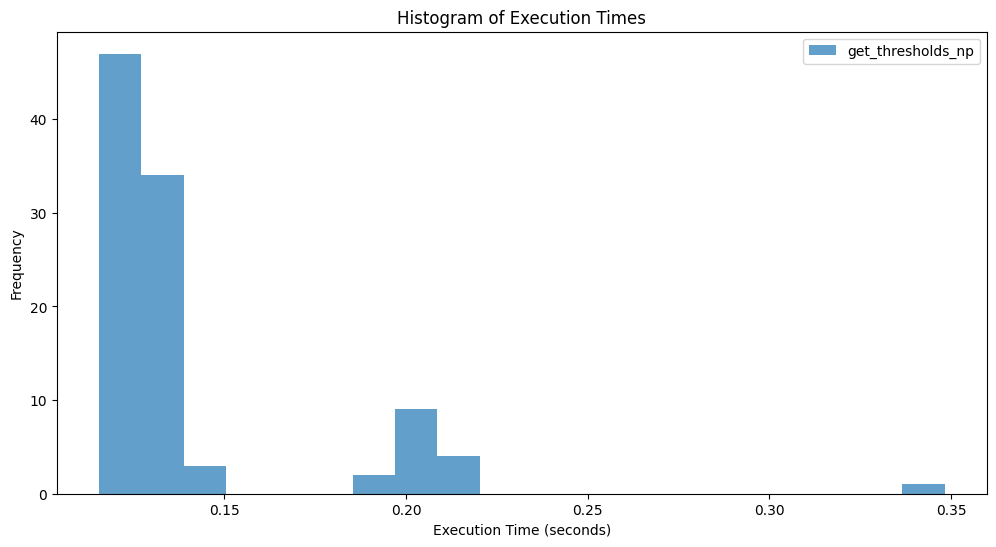

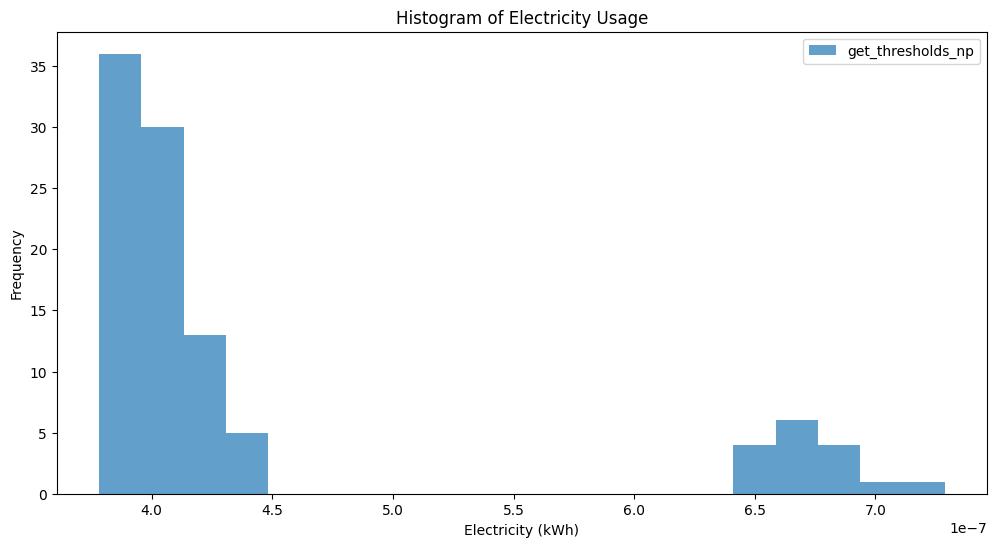

[codecarbon INFO @ 07:12:47] Energy consumed for RAM : 0.005366 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 07:12:47] Energy consumed for all CPUs : 0.047983 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:12:47] 0.053349 kWh of electricity used since the beginning.


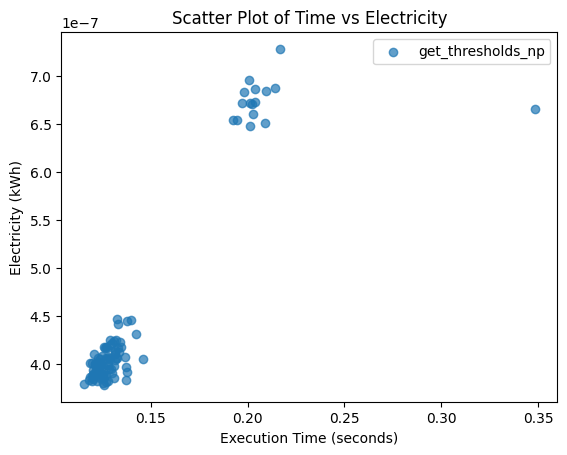

CPU times: user 1min 12s, sys: 1.17 s, total: 1min 14s
Wall time: 3min 25s


In [ ]:
%%time
run_simulations([get_thresholds_np], [key_scores, non_key_scores, K],100)

In [9]:
import operator
from random import shuffle
from bloom_filter import BloomFilter

In [10]:
items_counts = 20
fp_prob = 0.1

mu, sigma = 0.7, 0.2
scores_pre = np.random.normal(mu, sigma, 1000)
scores_pre = [item for item in scores_pre if (item >= 0 and item<=1.0)]

mu, sigma = 0.3, 0.2
scores_upre = np.random.normal(mu, sigma, 1000)
scores_upre=[item for item in scores_upre if (item >= 0 and item<=1.0)]

query_items=scores_pre+scores_upre
shuffle(query_items)

In [11]:
len(query_items)

1859

In [23]:
%%time
tracker.start()
i=0
j=0

bf = BloomFilter(items_counts, fp_prob)

for item in scores_pre:
    bf.add(str(item))

for item in query_items:
    if bf.check(str(item)):
       if item in scores_pre:
        i+=1
       else:
        j+=1
print(i,j)
tracker.stop()

[codecarbon WARNING @ 10:52:01] Already started tracking
[codecarbon WARNING @ 10:52:01] Tracker already stopped !
[codecarbon INFO @ 10:52:01] Energy consumed for RAM : 0.000083 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 10:52:01] Energy consumed for all CPUs : 0.000742 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:52:01] 0.000825 kWh of electricity used since the beginning.


926 933
CPU times: user 56.1 ms, sys: 0 ns, total: 56.1 ms
Wall time: 61.4 ms


0.00023548116451988586

In [12]:
scores_pre_np=np.array(scores_pre)
query_items_np=np.array(query_items)

In [19]:
%%time
tracker.start()
i=0
j=0

bf = BloomFilter(items_counts, fp_prob)

for item in scores_pre_np:
    bf.add(str(item))

for item in query_items_np:
    if bf.check(str(item)):
       if item in scores_pre_np:
        i+=1
       else:
        j+=1
print(i,j)
tracker.stop()

[codecarbon INFO @ 10:50:59] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 10:50:59] Energy consumed for all CPUs : 0.000000 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:50:59] 0.000001 kWh of electricity used since the beginning.


926 933
CPU times: user 50.6 ms, sys: 1.99 ms, total: 52.6 ms
Wall time: 61.5 ms


1.4473419103488135e-07

In [13]:
scores_pre_pd=pd.Series(scores_pre)
query_items_pd=pd.Series(query_items)

In [34]:
%%time
tracker.start()
i=0
j=0

bf = BloomFilter(items_counts, fp_prob)

for item in scores_pre_pd:
    bf.add(str(item))

for item in query_items_pd:
    if bf.check(str(item)):
       if item in scores_pre_pd.values:
        i+=1
       else:
        j+=1
print(i,j)
tracker.stop()

[codecarbon WARNING @ 11:04:16] Already started tracking
[codecarbon WARNING @ 11:04:16] Tracker already stopped !
[codecarbon INFO @ 11:04:16] Energy consumed for RAM : 0.001054 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 11:04:16] Energy consumed for all CPUs : 0.009418 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:04:16] 0.010472 kWh of electricity used since the beginning.


926 933
CPU times: user 46 ms, sys: 1.96 ms, total: 47.9 ms
Wall time: 50.5 ms


0.0029897645135316168

In [35]:
scores_pre_df=pd.DataFrame(scores_pre).iloc[:,0]
query_items_df=pd.DataFrame(query_items).iloc[:,0]

In [36]:
%%time
tracker.start()
i=0
j=0

bf = BloomFilter(items_counts, fp_prob)

for item in scores_pre_df:
    bf.add(str(item))

for item in query_items_df:
    if bf.check(str(item)):
       if item in scores_pre_df.values:
        i+=1
       else:
        j+=1
print(i,j)
tracker.stop()

[codecarbon WARNING @ 11:05:01] Already started tracking
[codecarbon WARNING @ 11:05:01] Tracker already stopped !
[codecarbon INFO @ 11:05:01] Energy consumed for RAM : 0.001113 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 11:05:01] Energy consumed for all CPUs : 0.009947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:05:01] 0.011059 kWh of electricity used since the beginning.


926 933
CPU times: user 63.3 ms, sys: 894 µs, total: 64.2 ms
Wall time: 121 ms


0.0031574232312688733

In [37]:
def bf_simu(scores_pre_series, query_items_series, items_counts, fp_prob):
    bf = BloomFilter(items_counts, fp_prob)

    for item in scores_pre_series:
        bf.add(str(item))

    i = 0
    j = 0

    for item in query_items_series:
        if bf.check(str(item)):
            if item in scores_pre_series.values:
                i += 1
            else:
                j += 1

    return i, j

In [ ]:
def run_simu_bloom(functions, args_list, num_runs=100):
    times = {func.__name__: [] for func in functions}
    electricity = {func.__name__: [] for func in functions}

    for func, args in zip(functions, args_list):
        for _ in range(num_runs):
            tracker = EmissionsTracker()

            start_time = time.time()
            tracker.start()
            result = func(*args)
            energy_consumed = tracker.stop()
            end_time = time.time()

            times[func.__name__].append(end_time - start_time)
            electricity[func.__name__].append(energy_consumed)


    for func_name, exec_times in times.items():
        plt.hist(exec_times, bins=20, alpha=0.7, label=func_name)

    plt.xlabel('Execution Time (seconds)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Execution Times')
    plt.legend()

    plt.figure(figsize=(12, 6))

    for func_name, exec_electricity in electricity.items():
        plt.hist(exec_electricity, bins=20, alpha=0.7, label=func_name)

    plt.xlabel('Electricity (kWh)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Electricity Usage')
    plt.legend()

    plt.show()

    for func_name in times:
        plt.scatter(times[func_name], electricity[func_name], alpha=0.7, label=func_name)

    plt.xlabel('Execution Time (seconds)')
    plt.ylabel('Electricity (kWh)')
    plt.title('Scatter Plot of Time vs Electricity')
    plt.legend()
    plt.show()

[codecarbon INFO @ 10:06:26] [setup] RAM Tracking...
[codecarbon INFO @ 10:06:26] [setup] GPU Tracking...
[codecarbon INFO @ 10:06:26] No GPU found.
[codecarbon INFO @ 10:06:26] [setup] CPU Tracking...
[codecarbon WARNING @ 10:06:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 10:06:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 10:06:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 10:06:27] >>> Tracker's metadata:
[codecarbon INFO @ 10:06:27]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 10:06:27]   Python version: 3.10.12
[codecarbon INFO @ 10:06:27]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 10:06:27]   Available RAM : 12.678 GB
[codecarbon INFO @ 10:06:27]   CPU count: 2
[codecarbon INFO @ 10:06:27]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 10:06:27]   GPU count: None
[cod

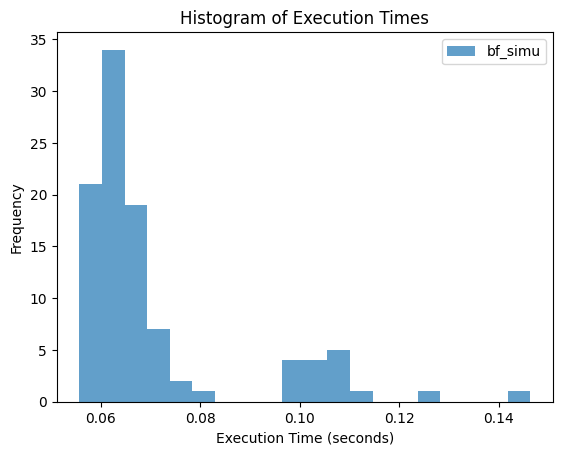

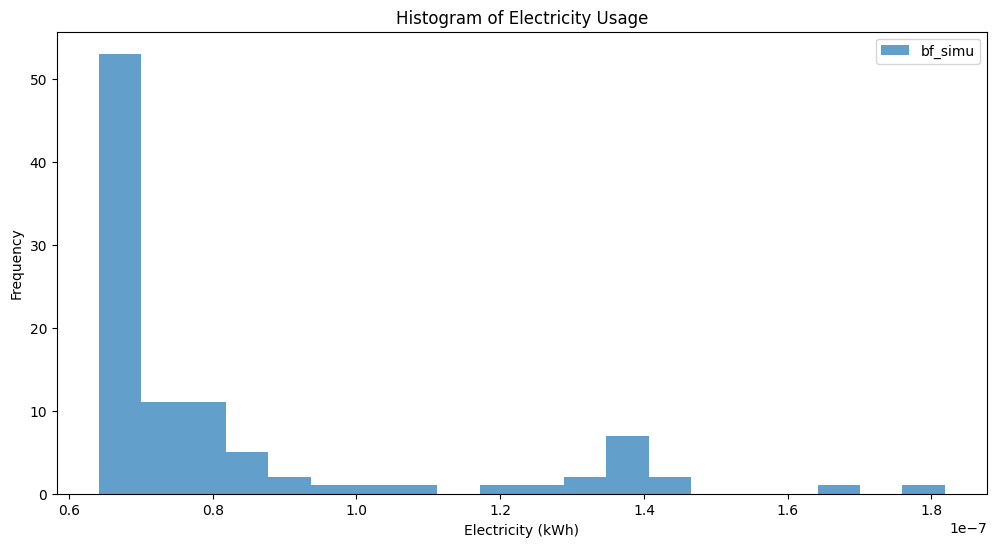

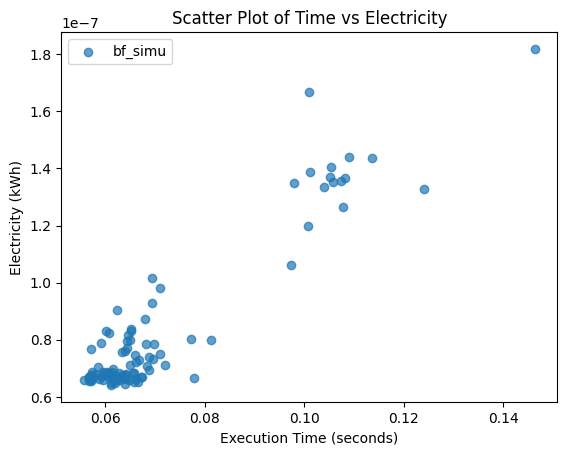

In [ ]:
### for pd serires
functions_to_test = [bf_simu]
args_to_test = [(scores_pre_pd, query_items_pd, items_counts, fp_prob)]

run_simu_bloom(functions_to_test, args_to_test, num_runs=100)

[codecarbon INFO @ 10:09:45] [setup] RAM Tracking...
[codecarbon INFO @ 10:09:45] [setup] GPU Tracking...
[codecarbon INFO @ 10:09:45] No GPU found.
[codecarbon INFO @ 10:09:45] [setup] CPU Tracking...
[codecarbon WARNING @ 10:09:45] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:09:45] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 10:09:45] Energy consumed for all CPUs : 0.005489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:09:45] 0.006102 kWh of electricity used since the beginning.
[codecarbon WARNING @ 10:09:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 10:09:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 10:09:46] >>> Tracker's metadata:
[codecarbon INFO @ 10:09:46]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 10:09:46]   Python version: 3.10.12

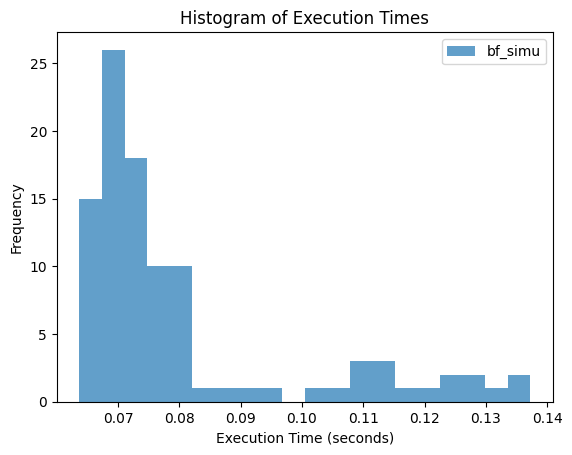

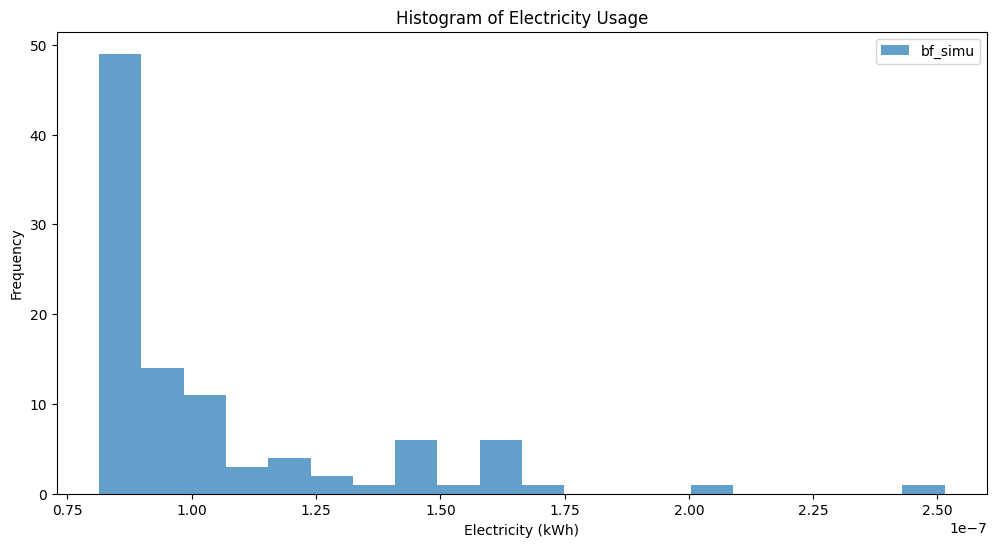

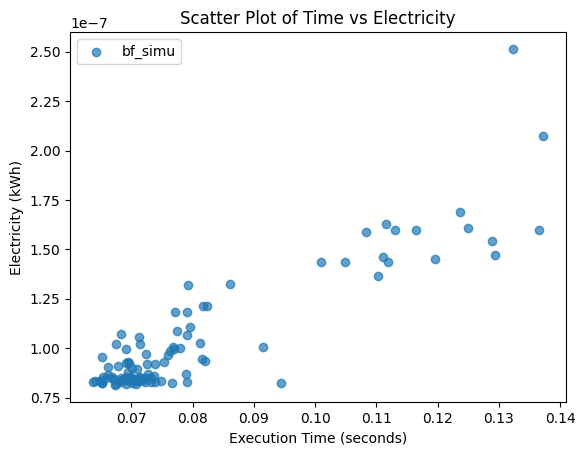

In [ ]:
### for np array
functions_to_test = [bf_simu]
args_to_test = [(scores_pre_np, query_items_np, items_counts, fp_prob)]

run_simu_bloom(functions_to_test, args_to_test, num_runs=100)

[codecarbon INFO @ 10:13:02] [setup] RAM Tracking...
[codecarbon INFO @ 10:13:02] [setup] GPU Tracking...
[codecarbon INFO @ 10:13:02] No GPU found.
[codecarbon INFO @ 10:13:02] [setup] CPU Tracking...
[codecarbon WARNING @ 10:13:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:13:03] Energy consumed for RAM : 0.019645 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 10:13:03] Energy consumed for all CPUs : 0.175646 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:03] 0.195290 kWh of electricity used since the beginning.
[codecarbon WARNING @ 10:13:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 10:13:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 10:13:04] >>> Tracker's metadata:
[codecarbon INFO @ 10:13:04]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 10:13:04]   Python version: 3.10.12

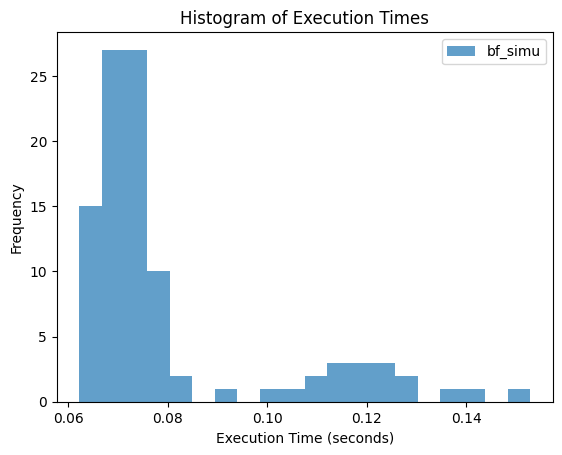

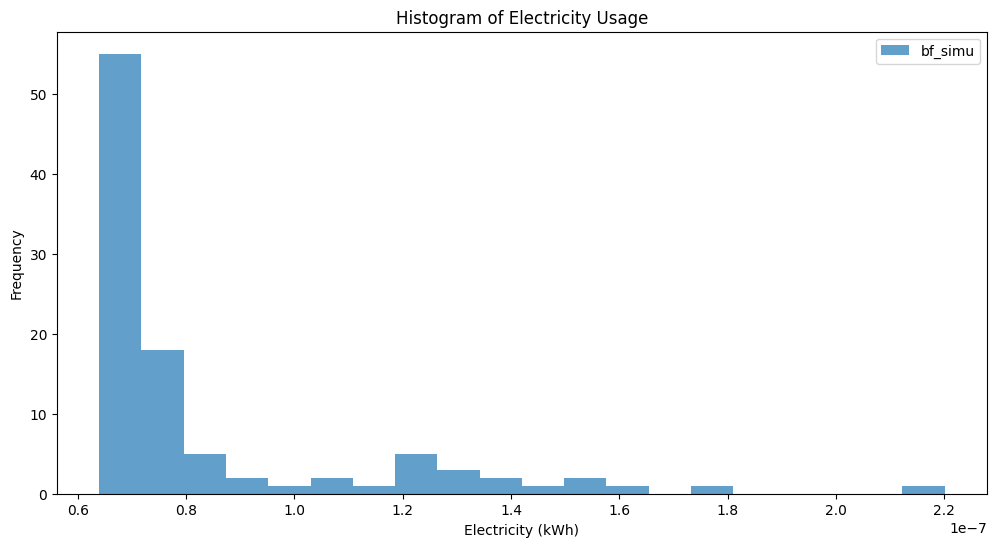

[codecarbon INFO @ 10:16:21] Energy consumed for RAM : 0.001228 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 10:16:21] Energy consumed for all CPUs : 0.010979 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:16:21] 0.012207 kWh of electricity used since the beginning.


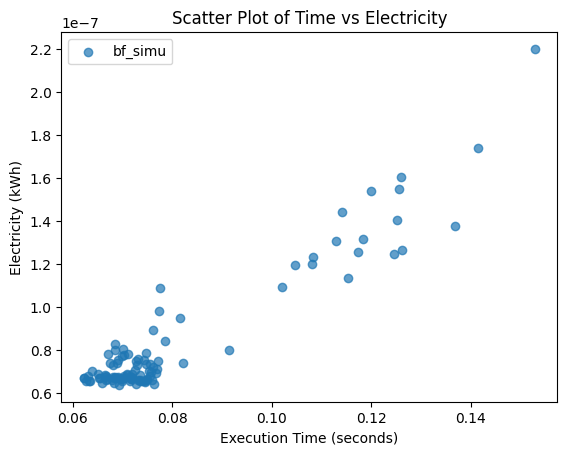

In [ ]:
### for df columns
functions_to_test = [bf_simu]
args_to_test = [(scores_pre_df[0], query_items_df[0], items_counts, fp_prob)]

run_simu_bloom(functions_to_test, args_to_test, num_runs=100)

[codecarbon INFO @ 10:21:44] [setup] RAM Tracking...
[codecarbon INFO @ 10:21:44] [setup] GPU Tracking...
[codecarbon INFO @ 10:21:44] No GPU found.
[codecarbon INFO @ 10:21:44] [setup] CPU Tracking...
[codecarbon WARNING @ 10:21:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:21:45] Energy consumed for RAM : 0.001564 kWh. RAM Power : 4.754376411437988 W
[codecarbon INFO @ 10:21:45] Energy consumed for all CPUs : 0.013989 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:45] 0.015554 kWh of electricity used since the beginning.
[codecarbon WARNING @ 10:21:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 10:21:47] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 10:21:47] >>> Tracker's metadata:
[codecarbon INFO @ 10:21:47]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 10:21:47]   Python version: 3.10.12

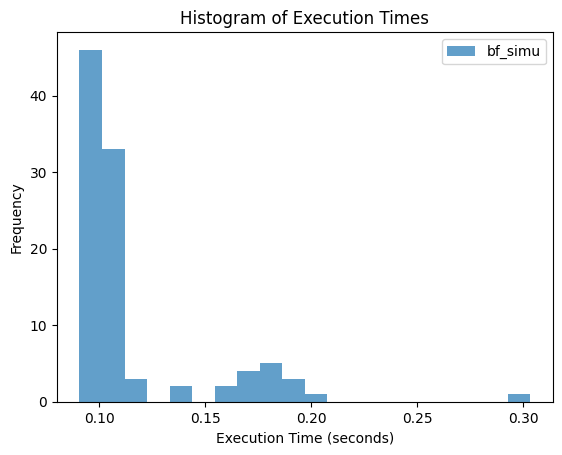

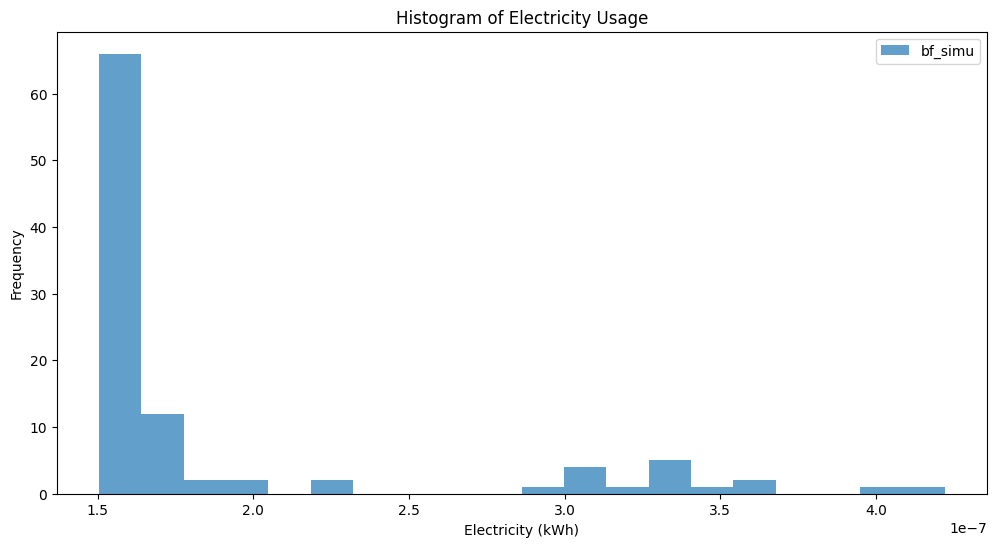

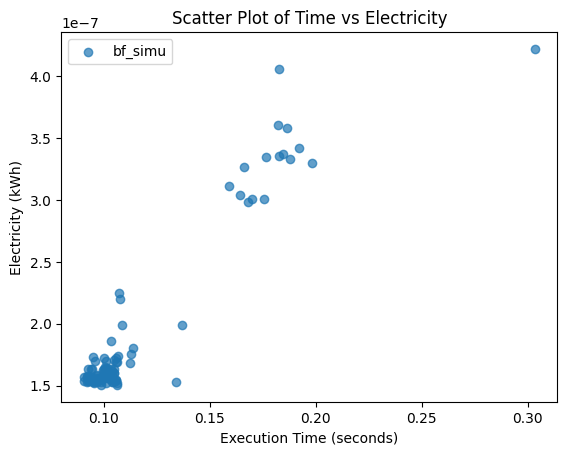

In [ ]:
### for list
functions_to_test = [bf_simu]
args_to_test = [(scores_pre, query_items, items_counts, fp_prob)]

run_simu_bloom(functions_to_test, args_to_test, num_runs=100)

In [38]:
bf_simu(scores_pre_df, query_items_df, items_counts, fp_prob)

(926, 933)

In [39]:
bf_simu(scores_pre_pd, query_items_pd, items_counts, fp_prob)

(926, 933)

In [41]:
def bf_simu2(scores_pre_series, query_items_series, items_counts, fp_prob):
    bf = BloomFilter(items_counts, fp_prob)

    for item in scores_pre_series:
        bf.add(str(item))

    i = 0
    j = 0

    for item in query_items_series:
        if bf.check(str(item)):
            if item in scores_pre_series:
                i += 1
            else:
                j += 1

    return i, j

In [42]:
bf_simu2(scores_pre_np, query_items_np, items_counts, fp_prob)

(926, 933)

In [43]:
bf_simu2(scores_pre, query_items, items_counts, fp_prob)

(926, 933)

In [44]:
def simus(func,num_runs=100):
    times = np.zeros(num_runs)
    electricity = np.zeros(num_runs)

    for i in range(num_runs):
        tracker = EmissionsTracker()
        start_time = time.time()
        tracker.start()
        result = func
        energy_consumed = tracker.stop()
        end_time = time.time()
        times[i]=end_time - start_time
        electricity[i]=energy_consumed
    return pd.DataFrame({'time' : times, 'electricity' : electricity, 'power':electricity/times})

In [52]:
%%capture
n=200
df_np=simus(bf_simu2(scores_pre_np, query_items_np, items_counts, fp_prob),n)
df_lst=simus(bf_simu2(scores_pre, query_items, items_counts, fp_prob),n)
df_pd=simus(bf_simu(scores_pre_pd, query_items_pd, items_counts, fp_prob),n)
df_df=simus(bf_simu(scores_pre_df, query_items_df, items_counts, fp_prob),n)

In [53]:
df_np['type']='np'
df_lst['type']='list'
df_pd['type']='pd'
df_df['type']='df'

In [54]:
df_all=pd.concat([df_lst, df_np,df_pd,df_df], ignore_index=True)
df_all.head()

,time,electricity,power,type
0,0.045473,5.406503e-09,1.188952e-07,list
1,0.046266,5.651875e-09,1.221602e-07,list
2,0.028410,4.492584e-09,1.581341e-07,list
3,0.027871,4.467634e-09,1.602989e-07,list
4,0.028828,4.928023e-09,1.709434e-07,list


In [56]:
df_all.to_csv('emissions_data.csv', index=False)

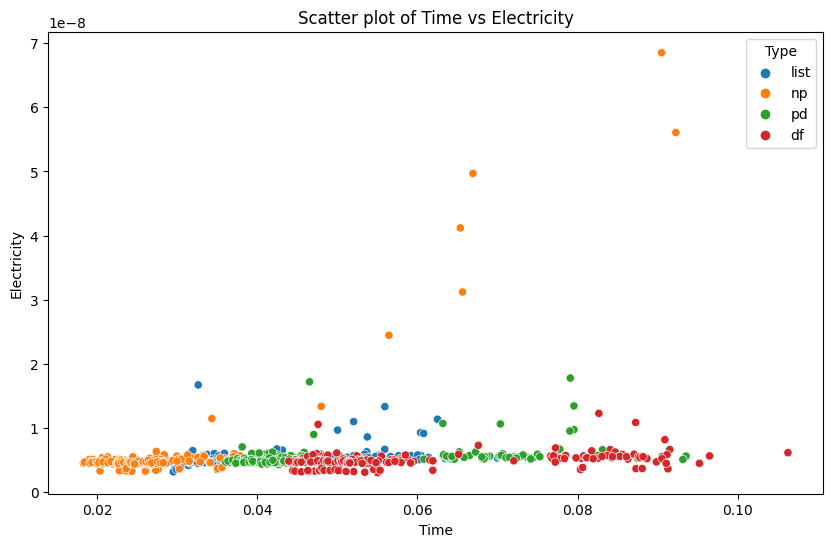

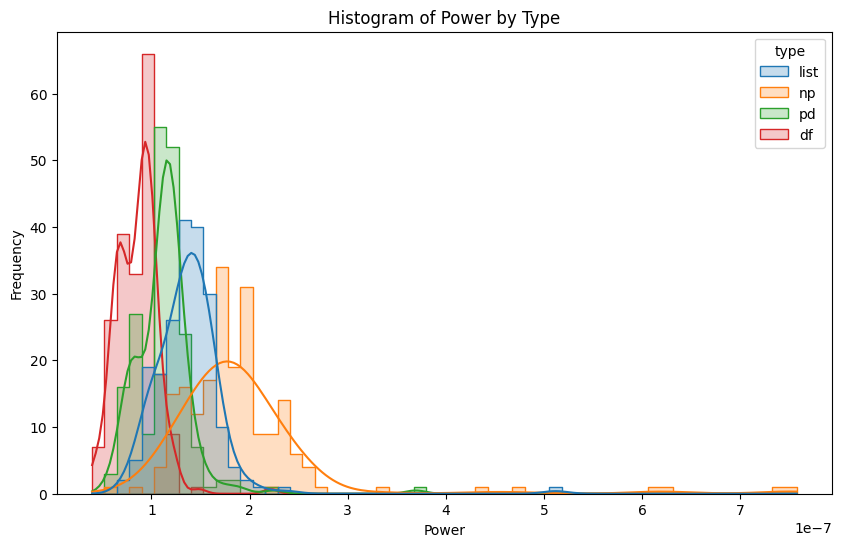

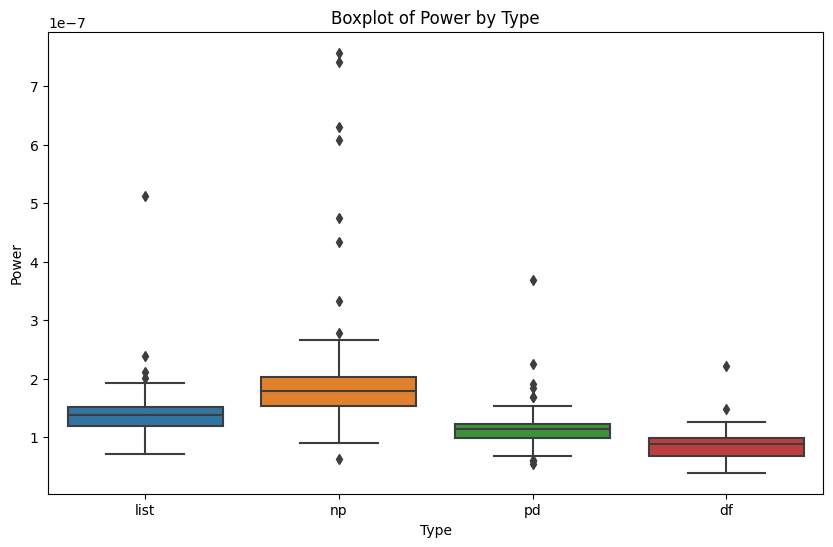

In [57]:
import seaborn as sns
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_all, x='time', y='electricity', hue='type')
plt.title('Scatter plot of Time vs Electricity')
plt.xlabel('Time')
plt.ylabel('Electricity')
plt.legend(title='Type')
plt.show()

# Histograms of power
plt.figure(figsize=(10, 6))
sns.histplot(data=df_all, x='power', hue='type', element="step", kde=True)
plt.title('Histogram of Power by Type')
plt.xlabel('Power')
plt.ylabel('Frequency')
plt.show()

# Boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='type', y='power')
plt.title('Boxplot of Power by Type')
plt.xlabel('Type')
plt.ylabel('Power')
plt.show()

- H0: There is no significant difference in the power for bloom filter computes  across different data types (list, numpy array, pandas series, pandas dataframe). $P_{L}= P_{np}=P_{pd}=P_{df}$

- H1: There is a significant difference in the power for bloom filter computes  across different data types (list, numpy array, pandas series, pandas dataframe).

In [60]:
from scipy import stats

f_value, p_value = stats.f_oneway(
    df_all[df_all['type'] == 'list']['power'],
    df_all[df_all['type'] == 'np']['power'],
    df_all[df_all['type'] == 'pd']['power'],
    df_all[df_all['type'] == 'df']['power']
)


print(f"F-value: {f_value}")
print(f"P-value: {p_value}")

F-value: 164.10377694858022
P-value: 8.315804339686641e-83
